In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from xgboost import XGBClassifier, plot_importance
import lightgbm as lgb
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix

from bayes_opt import BayesianOptimization

## Load Data

In [26]:
import dask.dataframe as dd # use dask to load dataset which exceeds memory
data = dd.read_csv('./data.csv', dtype={'attributed_time': 'object'})

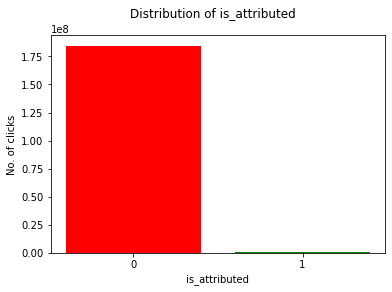

In [16]:
# obtain counts of each class # require 3 mins to load -- show the imbalance
data_0, data_1 = data["is_attributed"].value_counts()

#plot
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']
counts= [data_0, data_1]
ax.set_ylabel('No. of clicks')
ax.set_xlabel("is_attributed")
bars = ax.bar(labels, counts, color = ('red','green'))
plt.show()

We observe that:
1. Dataset is huge, with more than 175 million observations
2. Dataset is highly imbalanced

Thus, following will be the steps for data pre-processing:

1. Random sampling, where the final dataset we will be using will be approximately 0.25 of the size of the current dataset
2. Check for duplicates and remove them (if any)
3. Do train-test split
4. Undersampling on training set to balance the class distribution
5. Deal with missing data (if any)

## Data Pre-processing

### Random Sampling (without replacement)

In [2]:
# Read data by chunks of 10 million observations
# Sample 2.5 million observations randomly without replacement

data = pd.DataFrame()

chunksize = 10**7
with pd.read_csv('./data.csv', chunksize=chunksize) as reader:
  for chunk in reader:
    chunk = chunk.sample(n = int(chunksize/4), replace = False, random_state = 0)
    data = pd.concat([data, chunk])
    print(data.shape)

(2500000, 8)
(5000000, 8)
(7500000, 8)
(10000000, 8)
(12500000, 8)
(15000000, 8)
(17500000, 8)
(20000000, 8)
(22500000, 8)
(25000000, 8)
(27500000, 8)
(30000000, 8)
(32500000, 8)
(35000000, 8)
(37500000, 8)
(40000000, 8)
(42500000, 8)
(45000000, 8)
(47500000, 8)


In [28]:
print(data.shape)
print(data["is_attributed"].value_counts())

(47500000, 8)
0    47383465
1      116535
Name: is_attributed, dtype: int64


### Removing Duplicates

In [3]:
# Check for duplicates
print('Check whether there are duplicates:', data.duplicated().any())
print('Number of duplicates:', sum(data.duplicated(subset=list(data.columns))))

Check whether there are duplicates: True
Number of duplicates: 249747


In [4]:
data = data.drop_duplicates()

print(data.shape)
print(data["is_attributed"].value_counts())

(47250253, 8)
0    47133719
1      116534
Name: is_attributed, dtype: int64


Since attributed_time is only available when is_attributed=1, this feature will not provide much useful information for analytics. Thus, we decided to drop the attributed_time column.

In [5]:
# drop attributed time column
data = data.drop('attributed_time', axis=1)
data.head()

,ip,app,device,os,channel,click_time,is_attributed
9487273,159670,2,1,19,435,2017-11-07 00:03:10,0
1409143,81834,6,1,3,125,2017-11-06 16:32:41,0
4861323,2896,12,1,17,245,2017-11-06 20:07:33,0
1226788,140931,64,1,15,459,2017-11-06 16:27:49,0
5698172,121966,1,1,1,134,2017-11-06 21:57:34,0


In [6]:
data.to_csv('./data_sampled.csv', index=False)

### Train-test split

In [33]:
data = pd.read_csv('./data_sampled.csv')

In [7]:
X = data.iloc[:,:-1]
y = data["is_attributed"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape, X_test.shape)
print(X_train.columns)

(37800202, 6) (9450051, 6)
Index(['ip', 'app', 'device', 'os', 'channel', 'click_time'], dtype='object')


### Save sampled train and test datasets

In [8]:
y_train = pd.DataFrame({'is_attributed': y_train})
y_test = pd.DataFrame({'is_attributed': y_test})

In [9]:
train_sampled = pd.concat([X_train, y_train],  axis=1)
test_sampled = pd.concat([X_test, y_test],  axis=1)
train_sampled.to_csv('./train_sampled.csv', index=False)
test_sampled.to_csv('./test_sampled.csv', index=False)

In [37]:
#Check; can comment out later
train_sampled.head(5)

,ip,app,device,os,channel,click_time,is_attributed
46352771,304834,20,1,17,259,2017-11-09 15:58:50,0
40854578,55874,3,1,13,371,2017-11-09 09:24:01,0
657306,55988,12,1,22,259,2017-11-06 16:25:11,0
4681899,204669,15,1,13,245,2017-11-07 00:54:21,0
5771510,68632,14,1,19,401,2017-11-07 03:13:22,0


### Undersampling

In [38]:
def undersample(train):
  train_0 = train[train["is_attributed"] == 0]
  train_1 = train[train["is_attributed"] == 1]

  train_0_count, train_1_count = train["is_attributed"].value_counts()

  # Under-sample class 0
  train_0_under = train_0.sample(n = train_1_count, random_state = 0)

  # Merge undersampled class 0 and original class 1
  train_under = pd.concat([train_0_under, train_1], axis = 0)
  return train_under

In [39]:
train_undersampled = undersample(train_sampled)

print(train_undersampled.shape)
print(train_undersampled["is_attributed"].value_counts())

(186454, 7)
0    93227
1    93227
Name: is_attributed, dtype: int64


In [ ]:
## Save undersampled data
train_undersampled.to_csv('./train_undersampled.csv', index=False)

## (Starting Point) Load Undersampled Train CSV Data

I have run and saved a copy of the unsampled data, I think can just start from here instead of running the undersampling process everytime

In [22]:
train = pd.read_csv('./train_undersampled.csv')
train.head()

,ip,app,device,os,channel,click_time,is_attributed
0,116992,15,1,34,245,2017-11-07 06:18:26,0
1,92610,3,1,13,280,2017-11-07 03:06:29,0
2,79894,2,1,19,122,2017-11-07 11:15:24,0
3,32746,3,1,31,480,2017-11-08 14:44:58,0
4,1638,2,1,20,236,2017-11-09 10:24:38,0


In [23]:
train["is_attributed"].value_counts()

0    93227
1    93227
Name: is_attributed, dtype: int64

In [24]:
# Redefine X_train and y_train
X_train, y_train = train.iloc[:,:-1], train["is_attributed"]

print(X_train.shape, y_train.shape)

(186454, 6) (186454,)


# Exploratory Data Analysis

### 1. Count of unique values of variables

In [25]:
unique_values = []

for x in train.iloc[:,:-1].columns:
  unique_values.append(len(train[x].unique()))

print(len(unique_values))
print(unique_values)

6
[84781, 243, 955, 148, 172, 124815]


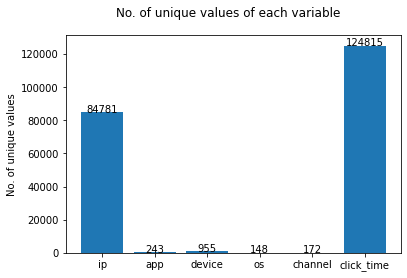

In [26]:
fig, ax = plt.subplots()
fig.suptitle('No. of unique values of each variable')
labels = train.iloc[:,:-1].columns.tolist()

ax.set_ylabel('No. of unique values')
ax.bar(labels, unique_values)

for index, value in enumerate(unique_values):
    ax.text(x = index, y = value, s=str(value), fontdict=dict(fontsize=10), ha="center")

### 1. Distribution of is_attributed



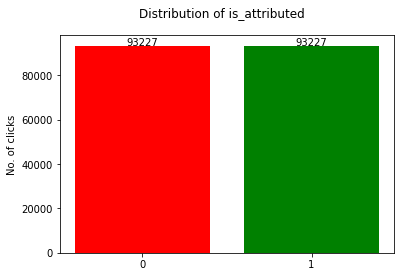

In [27]:
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, train['is_attributed'].value_counts(), color = ('red','green'))

for index, value in enumerate(train['is_attributed'].value_counts()):
    ax.text(x = index, y = value, s=str(value), fontdict=dict(fontsize=10), ha="center")

### 2. Time of Day for Clicks (in hour)

Extract day, hour, minute, second from click_time

In [28]:
train_datetime = pd.to_datetime(train['click_time'], format='%Y-%m-%d %H:%M:%S')
train['click_time'] = train_datetime
train['day'] = train_datetime.dt.day
train['hour'] = train_datetime.dt.hour
train['minute'] = train_datetime.dt.minute
train['second'] = train_datetime.dt.second

print(train.head())

       ip  app  device  os  channel          click_time  is_attributed  day  \
0  116992   15       1  34      245 2017-11-07 06:18:26              0    7   
1   92610    3       1  13      280 2017-11-07 03:06:29              0    7   
2   79894    2       1  19      122 2017-11-07 11:15:24              0    7   
3   32746    3       1  31      480 2017-11-08 14:44:58              0    8   
4    1638    2       1  20      236 2017-11-09 10:24:38              0    9   

   hour  minute  second  
0     6      18      26  
1     3       6      29  
2    11      15      24  
3    14      44      58  
4    10      24      38  


In [29]:
train_hour_0 = train[train["is_attributed"] == 0]['hour']
train_hour_1 = train[train["is_attributed"] == 1]['hour']

train_min_0 = train[train["is_attributed"] == 0]['minute']
train_min_1 = train[train["is_attributed"] == 1]['minute']

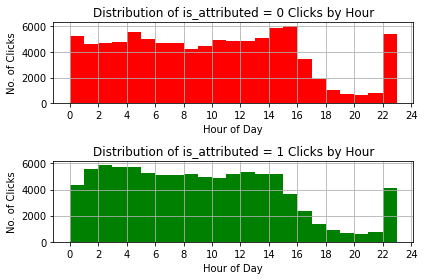

In [30]:
hours = 24 # 24 hours in a day

# Histogram for fraud clicks
plt.subplot(2, 1, 1)
train_hour_0.hist(bins = hours - 1, color = "red")
plt.xlabel("Hour of Day")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 0 Clicks by Hour")
plt.locator_params(axis = "x", nbins = hours)

# Histogram for normal clicks
plt.subplot(2, 1, 2)
train_hour_1.hist(bins = hours - 1, color = "green")
plt.xlabel("Hour of Day")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 1 Clicks by Hour")
plt.locator_params(axis = "x", nbins = hours)

plt.tight_layout()
plt.show()

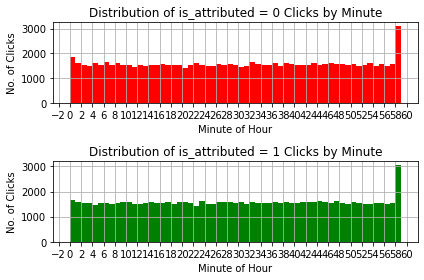

In [31]:
minutes = 60 # 60 minutes in an hour

# Histogram for fraud clicks
plt.subplot(2, 1, 1)
train_min_0.hist(bins = minutes - 1, color = "red")
plt.xlabel("Minute of Hour")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 0 Clicks by Minute")
plt.locator_params(axis = "x", nbins = minutes)

# Histogram for normal clicks
plt.subplot(2, 1, 2)
train_min_1.hist(bins = minutes - 1, color = "green")
plt.xlabel("Minute of Hour")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 1 Clicks by Minute")
plt.locator_params(axis = "x", nbins = minutes)

plt.tight_layout()
plt.show()

### 3. Average Number of Clicks

In [32]:
train_0 = train[train["is_attributed"] == 0]
train_1 = train[train["is_attributed"] == 1]

num_ip_0 = train_0['ip'].nunique()
num_ip_1 = train_1['ip'].nunique()

num_app_0 = train_0['app'].nunique()
num_app_1 = train_1['app'].nunique()

num_clicks_0 = train_0.size
num_clicks_1 = train_1.size

avg_clicks_ip_0 = num_clicks_0 / num_ip_0
avg_clicks_ip_1 = num_clicks_1 / num_ip_1

avg_clicks_app_0 = num_clicks_0 / num_app_0
avg_clicks_app_1 = num_clicks_1 / num_app_1

print(num_ip_0, num_ip_1)
print(num_app_0, num_app_1)

33418 67422
165 174


<BarContainer object of 2 artists>

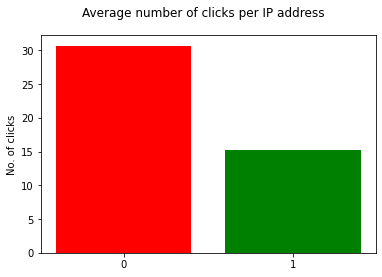

In [33]:
fig, ax = plt.subplots()
fig.suptitle('Average number of clicks per IP address')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, (avg_clicks_ip_0, avg_clicks_ip_1), color = ('red','green'))

Great difference between the two classes

<BarContainer object of 2 artists>

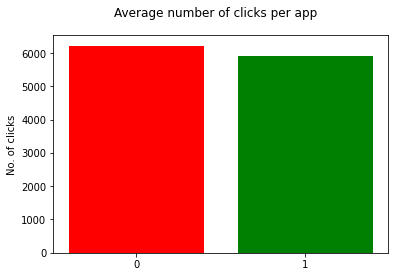

In [34]:
fig, ax = plt.subplots()
fig.suptitle('Average number of clicks per app')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, (avg_clicks_app_0, avg_clicks_app_1), color = ('red','green'))

### 4. Distribution of Device


In [35]:
fraud_data = train[train["is_attributed"] == 0]
notfraud_data = train[train["is_attributed"] == 1]

In [36]:
device_labels = sorted(train["device"].unique().tolist())
device_fraud = []
device_notfraud = []

for device in device_labels:
  device_fraud.append(len(fraud_data[fraud_data["device"] == device]))
  device_notfraud.append(len(notfraud_data[notfraud_data["device"] == device]))

device_labels = [str(x) for x in device_labels]

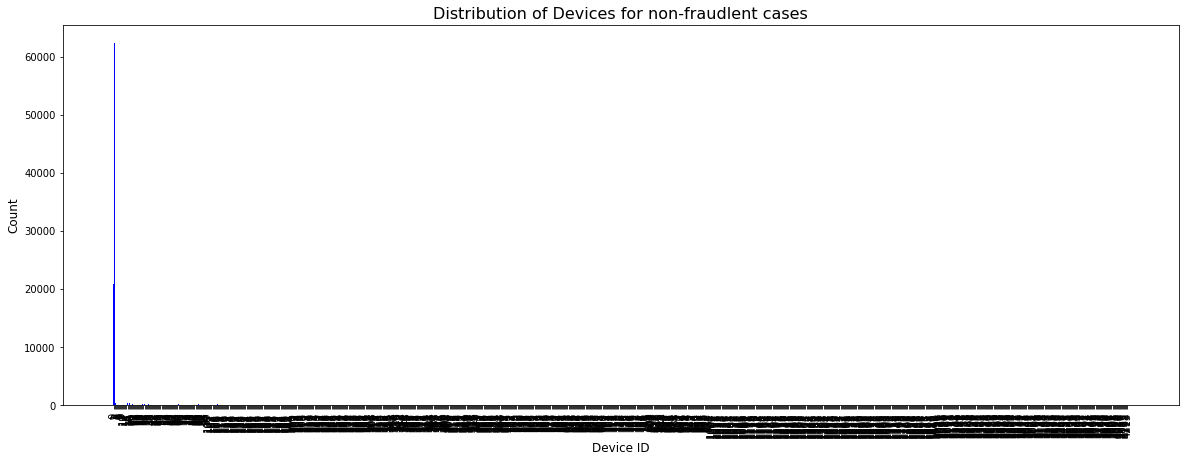

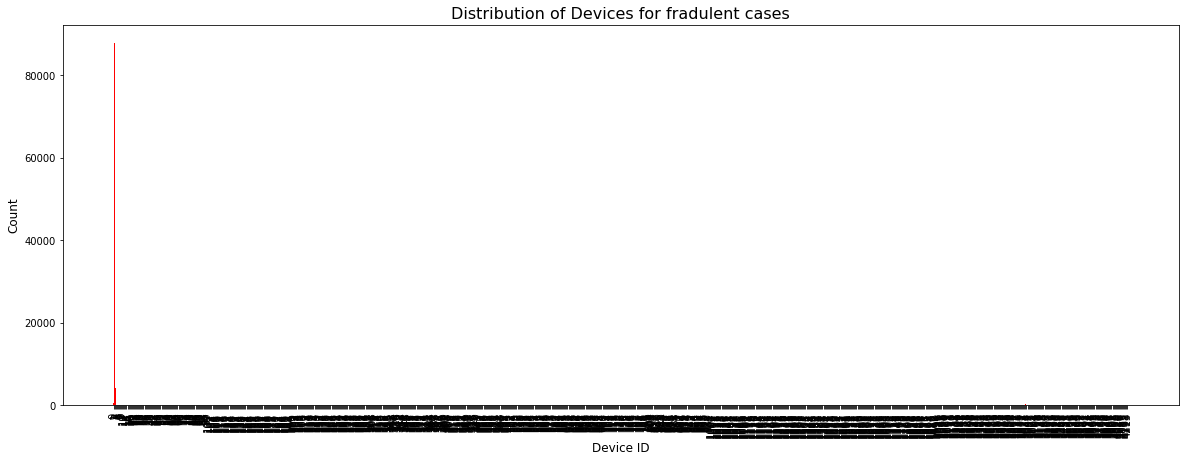

In [37]:
# Not fradulent
plt.figure(figsize = (20, 7))
plt.bar(x = device_labels,
        height = device_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of Devices for non-fraudlent cases", fontsize = 16) 
plt.xlabel("Device ID", fontsize = 12)

  # Option 1: Using normal scale  
plt.ylabel("Count", fontsize = 12)

  # Option 2: Using log scale
# plt.yscale('log')
# plt.ylabel("Log of Count", fontsize = 12)

plt.show()


# Fradulent
plt.figure(figsize = (20, 7))
plt.bar(x = device_labels,
        height = device_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of Devices for fradulent cases", fontsize = 16) 
plt.xlabel("Device ID", fontsize = 12)

  # Option 1: Using normal scale 
plt.ylabel("Count", fontsize = 12)

  # Option 2: Using log scale
# plt.yscale('log')
# plt.ylabel("Log of Count", fontsize = 12)

plt.show()

In [38]:
# For checks
print("Device Labels are: ", "\n", device_labels)
print("Non fradulent counts are: ", "\n", device_notfraud)
print("Fradulent counts are: ", "\n", device_fraud)

Device Labels are:  
 ['0', '1', '2', '4', '5', '6', '7', '8', '9', '10', '11', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '49', '50', '51', '52', '53', '54', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '82', '83', '84', '86', '87', '88', '89', '90', '92', '94', '95', '96', '97', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '112', '113', '114', '115', '116', '118', '119', '122', '123', '124', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '140', '141', '142', '144', '145', '147', '148', '149', '150', '152', '153', '154', '155', '156', '157', '159', '160', '161', '162', '163', '165', '166', '167', '168', '169', '170', '171', '172', '173', '177', '179', '180

### 5. Distribution of Channel

In [39]:
channel_labels = sorted(train["channel"].unique().tolist())
channel_fraud = []
channel_notfraud = []

for channel in channel_labels:
  channel_fraud.append(len(fraud_data[fraud_data["channel"] == channel]))
  channel_notfraud.append(len(notfraud_data[notfraud_data["channel"] == channel]))

channel_labels = [str(x) for x in channel_labels]

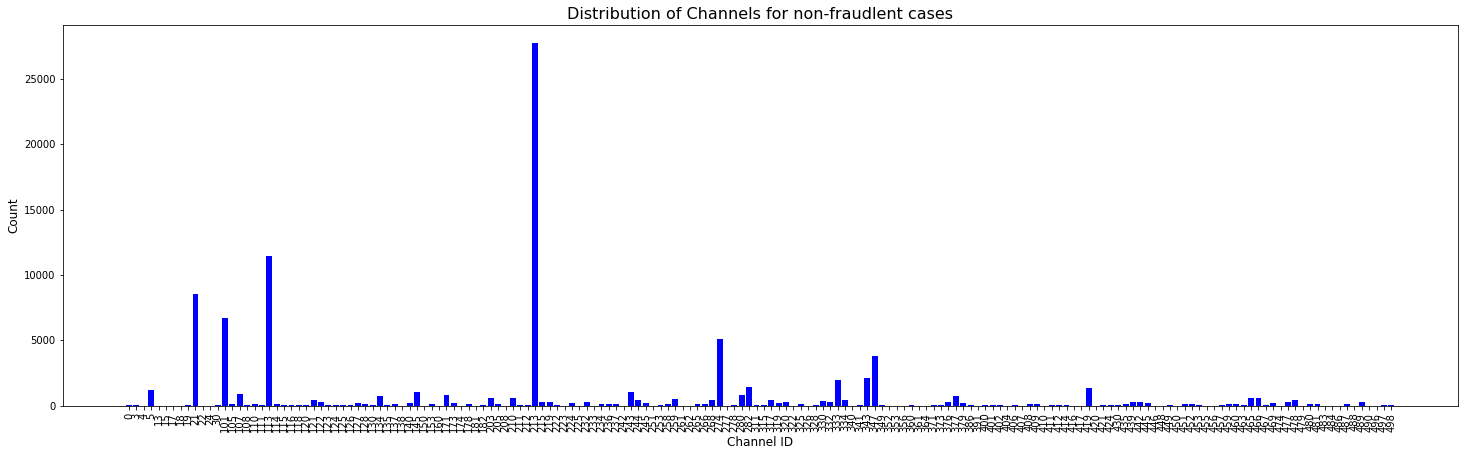

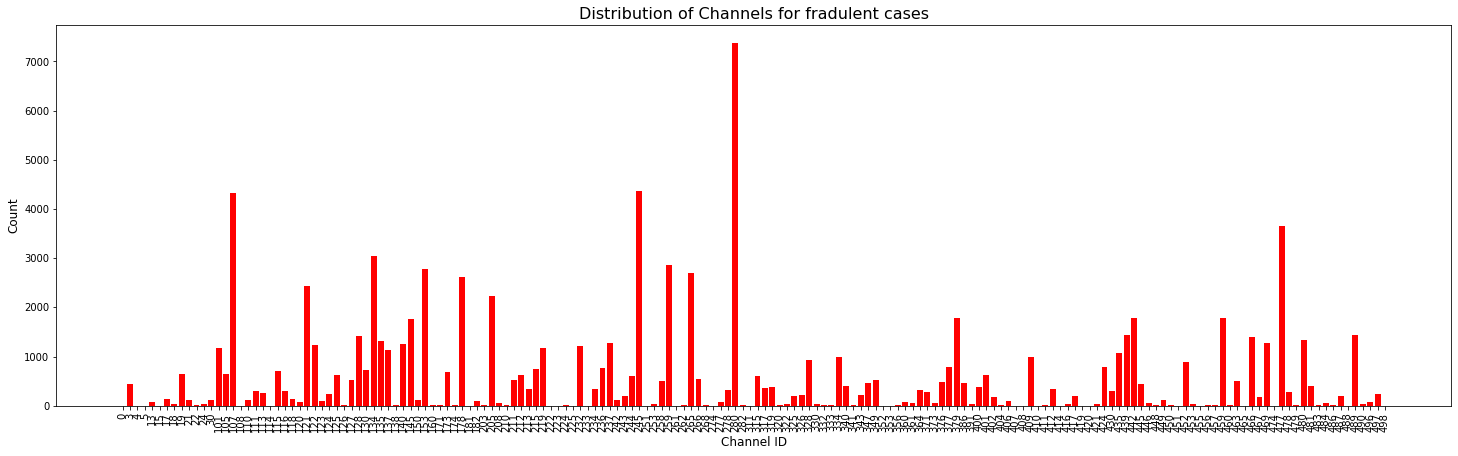

In [40]:
# Not fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = channel_labels,
        height = channel_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of Channels for non-fraudlent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

# Fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = channel_labels,
        height = channel_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of Channels for fradulent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

plt.show()

In [41]:
# For checks
print("Channel Labels are: ", "\n", channel_labels)
print("Non fradulent counts are: ", "\n", channel_notfraud)
print("Fradulent counts are: ", "\n", channel_fraud)

Channel Labels are:  
 ['0', '3', '4', '5', '13', '15', '17', '18', '19', '21', '22', '24', '30', '101', '105', '107', '108', '110', '111', '113', '114', '115', '116', '118', '120', '121', '122', '123', '124', '125', '126', '127', '128', '130', '134', '135', '137', '138', '140', '145', '150', '153', '160', '171', '173', '174', '178', '181', '182', '203', '205', '208', '210', '211', '212', '213', '215', '219', '222', '223', '224', '225', '232', '233', '234', '236', '237', '242', '243', '244', '245', '251', '253', '258', '259', '261', '262', '265', '266', '268', '274', '277', '278', '280', '282', '311', '315', '317', '319', '320', '322', '325', '326', '328', '330', '332', '333', '334', '340', '341', '343', '347', '349', '352', '353', '356', '360', '361', '364', '371', '373', '376', '377', '379', '386', '391', '400', '401', '402', '404', '406', '407', '408', '409', '410', '411', '412', '414', '416', '417', '419', '420', '421', '424', '430', '435', '439', '442', '445', '446', '448', '449',

### 6. Distribution of IP

In [42]:
ip_labels = sorted(train["ip"].unique().tolist())
ip_fraud = []
ip_notfraud = []

for ip in ip_labels:
  ip_fraud.append(len(fraud_data[fraud_data["ip"] == ip]))
  ip_notfraud.append(len(notfraud_data[notfraud_data["ip"] == ip]))

ip_labels = [str(x) for x in ip_labels]

In [ ]:
# Not fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = ip_labels,
        height = ip_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of IP addresses for non-fraudlent cases", fontsize = 16) 
plt.xlabel("IP Adress", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

# Fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = ip_labels,
        height = ip_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of IP addresses for fradulent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

plt.show()

In [ ]:
# For checks
print("IP Labels are: ", "\n", ip_labels)
print("Non fradulent counts are: ", "\n", ip_fraud)
print("Fradulent counts are: ", "\n", ip_notfraud)

### 7. Distribution of OS

In [ ]:
plt.figure(figsize=(20, 15))
ax = sns.countplot(x="os", hue="is_attributed", data=train)
ax.set_yscale("log")
ax.legend(loc="upper right")
# generate graph xlabels
attributed_os = train[train["is_attributed"]==1]["os"].unique()
os_xlabels = [str(i) if i in attributed_os else "" for i in sorted(train["os"].unique())]
ax.set_xticklabels(os_xlabels, fontsize=8)
ax.set_title("Distribution of OS")
plt.show()

In [44]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'conversion_rate']
merge

,os,click_count,conversion_rate
0,19,38575,0.421854
1,13,32431,0.383183
2,24,9999,0.983598
3,0,7944,0.979481
4,17,7309,0.319469
...,...,...,...
143,136,1,0.000000
144,117,1,0.000000
145,131,1,1.000000
146,122,1,0.000000


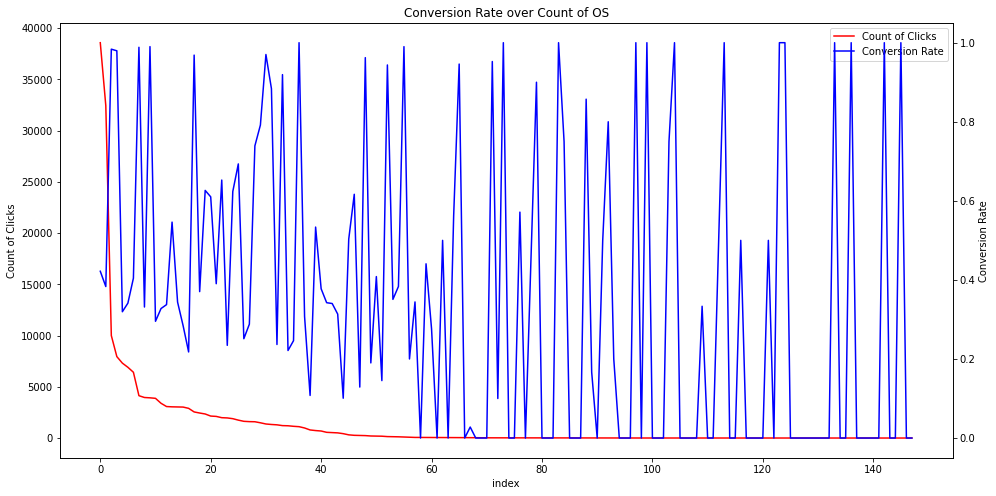

In [45]:
fig,ax = plt.subplots(figsize=(16, 8))

l1 = ax.plot(merge.click_count, color="red", label="Count of Clicks")
#ax.set_yscale("log")
ax.set_ylabel("Count of Clicks")

ax2=ax.twinx()
l2 = ax2.plot(merge.conversion_rate, color="blue", label="Conversion Rate")
ax2.set_ylabel("Conversion Rate")

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="best")
ax.set_xlabel("index")
ax.set_title("Conversion Rate over Count of OS")
plt.show()

### 8. Average Time between Clicks

In [46]:
from datetime import datetime

sorted_ip = sorted(train["ip"].unique())
sorted_ip_attributed = sorted(train[train["is_attributed"]==1]["ip"].unique())
click_average_time_0 = []
click_average_time_1 = []

def get_average_time(click_time):
  count = len(click_time)
  # assign -1 if click once
  if count <= 1:
    return -1
  else:
    start_time = datetime.strptime(click_time[0], '%Y-%m-%d %H:%M:%S')
    end_time = datetime.strptime(click_time[count-1], '%Y-%m-%d %H:%M:%S')
    difference = (end_time - start_time).total_seconds()/60
    if difference == 0:
      return 0
    else:
      return difference/(count-1)

for ip in sorted_ip:
  click_time = sorted(train[train["ip"]==ip]["click_time"].values)
  average_time = get_average_time(click_time)
  # remove -1 values for better visualization
  if average_time != -1:
    if ip in sorted_ip_attributed:
      click_average_time_1.append(average_time)
    else:
      click_average_time_0.append(average_time)


TypeError: strptime() argument 1 must be str, not numpy.datetime64

In [ ]:
plt.figure(figsize=(20, 15))
ax = sns.histplot([click_average_time_0, click_average_time_1], multiple = "stack")
ax.set_xlabel("Time (in minutes)")
ax.set_title("Average Time between Clicks")
plt.show()

In [ ]:
rng = range(int(min(click_average_time_0)), int(max(click_average_time_0)) + 60, 60)

fig, axes = plt.subplots(2, 1, figsize=(20, 15))
# Histogram for fraud clicks
sns.histplot(click_average_time_0, ax = axes[0], bins = rng, color = "red")
axes[0].set_xlabel("Time (in minutes)")
axes[0].set_title("Average Time between Fraud Clicks")

# Histogram for normal clicks
sns.histplot(click_average_time_1, ax = axes[1], bins = rng, color = "green")
axes[1].set_xlabel("Time (in minutes)")
axes[1].set_title("Average Time between Normal Clicks")

plt.show()

### 10. Conversion Rate between clicky IP and non clicky IP

In [ ]:
#work with categorical varibles
categorical = train[["ip", "app", "device", "os", "channel", "is_attributed"]].apply(lambda x: x.astype("category"))
categorical.is_attributed = categorical.is_attributed.astype(int)
categorical.is_attributed.value_counts()

In [ ]:
#each ip can have multiple clicks
train["ip"].value_counts()

In [ ]:
#conversion rate just by looking at ip
#can have multiple downloads per ip
agg_func_count = {"is_attributed": ["count", "sum"]}
x = train.groupby(["ip"]).agg(agg_func_count)
x.columns = ["clicks", "downloads"]
x = x.sort_values('clicks', ascending=False).reset_index()
x["conversion_rate"] = x.downloads/x.clicks
x.head()

In [ ]:
#comparing clicks and conversion rate for top 500 ip addresses
#whether there is download seem pretty random, does not really seem to be related to ip
fig,ax = plt.subplots(figsize=(12,6))

l1 = ax.plot(x.clicks[:500], color="red", marker="o", label="count")
ax.set_ylabel("clicks")

ax2=ax.twinx()
l2 = ax2.plot(x.conversion_rate[:500], color="blue", marker="o", label="conversion")
ax2.set_ylabel("conversion rate")

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="best")
ax.set_xlabel("index")
ax.set_title("Top 500 ip with most clicks")
plt.show()

### 11. Channel and Conversion Rate

In [ ]:
train['click_date'] = train_datetime.dt.date
train['dateTime'] = pd.to_datetime(train.click_date) + pd.to_timedelta(train.hour, unit='h')
train_isAttributed = train[train['is_attributed'] == 1]

In [ ]:
number_click_channel = pd.DataFrame(train.groupby(by=["channel"]).size()).reset_index()
number_click_channel = number_click_channel.rename({0: 'count'}, axis=1)
number_click_channel.rename(columns={'count':'number_click'}, inplace=True)

number_download_channel = pd.DataFrame(train_isAttributed.groupby(by=["channel"]).size()).reset_index()
number_download_channel = number_download_channel.rename({0: 'count'}, axis=1)
number_download_channel.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_channel = number_click_channel.join(number_download_channel.set_index('channel'), on="channel")
conversion_rate_channel['number_download'] = conversion_rate_channel['number_download'].fillna(0)
conversion_rate_channel['conversion_rate'] = conversion_rate_channel['number_download']/conversion_rate_channel['number_click']

In [ ]:
conversion_rate_channel.head(5)

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=conversion_rate_channel, x='channel', y='conversion_rate')
ax.set_xlabel("Channel")
ax.set_title("Conversion Rate")
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

### 12. Device and Conversion Rate

In [ ]:
number_click_device = pd.DataFrame(train.groupby(by=["device"]).size()).reset_index()
number_click_device = number_click_device.rename({0: 'count'}, axis=1)
number_click_device.rename(columns={'count':'number_click'}, inplace=True)

number_download_device = pd.DataFrame(train_isAttributed.groupby(by=["device"]).size()).reset_index()
number_download_device = number_download_device.rename({0: 'count'}, axis=1)
number_download_device.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_device = number_click_device.join(number_download_device.set_index('device'), on="device")
conversion_rate_device['number_download'] = conversion_rate_device['number_download'].fillna(0)
conversion_rate_device['conversion_rate'] = conversion_rate_device['number_download']/conversion_rate_device['number_click']

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data=conversion_rate_device, x='device', y='conversion_rate')
ax.set_xlabel("Device")
ax.set_title("Conversion Rate")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

### 13. Click and Conversion Rate throughout the day

In [ ]:
number_click_time = pd.DataFrame(train.groupby(by=["dateTime"]).size()).reset_index()
number_click_time = number_click_time.rename({0: 'count'}, axis=1)
number_click_time.rename(columns={'count':'number_click'}, inplace=True)

number_download_time= pd.DataFrame(train_isAttributed.groupby(by=["dateTime"]).size()).reset_index()
number_download_time = number_download_time.rename({0: 'count'}, axis=1)
number_download_time.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_time = number_click_time.join(number_download_time.set_index('dateTime'), on="dateTime")
conversion_rate_time['number_download'] = conversion_rate_time['number_download'].fillna(0)
conversion_rate_time['conversion_rate'] = conversion_rate_time['number_download']/conversion_rate_time['number_click']
conversion_rate_time = conversion_rate_time.set_index('dateTime')

In [ ]:
# setting figure size to 12, 10
fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()
# Labelling the axes and setting
# a title
ax.set_xlabel("Date")
ax.set_ylabel("Conversion Rate")
ax2.set_ylabel("Number of Clicks")
ax.set_title("Click and Conversion Rate Time Series")

# plotting the "A" column alone
p1, = ax.plot(conversion_rate_time['conversion_rate'],  color='green', marker='x', label='Conversion Rate')
p2, = ax2.plot(conversion_rate_time['number_click'], marker='o', label="Number of Clicks")
ax.set_xticklabels(conversion_rate_time.index, rotation=-80)
plt.legend(handles=[p1,p2],bbox_to_anchor=(1.2, 1), loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
ax2.yaxis.grid(False)
plt.show()

#  Feature Engineering

### Different combination/aggregation of features

In [7]:
#functions to help aggregate and count

#total counts
def agg_counts(df, group_cols, name):
  grp = df.groupby(group_cols).size().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df


#unique counts
def agg_unique(df, group_cols, unique_col, name):
  grp = df.groupby(group_cols)[unique_col].nunique().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df


#cumulative counts
def agg_cum_count(df, group_cols, name):
  grp = df.groupby(group_cols).cumcount()
  df[name] = grp.values
  return df

#variance
def agg_var(df, group_cols, counted, name):
    grp = df.groupby(group_cols)[counted].var().rename(name).to_frame().reset_index()
    df = df.merge(grp, on=group_cols, how='left')
    return df

#mean
def agg_mean(df, group_cols, counted, name):
    grp = df.groupby(group_cols)[counted].mean().rename(name).to_frame().reset_index()
    df = df.merge(grp, on=group_cols, how='left')
    return df

In [ ]:
#data to do combi on 
train_agg = train.copy()
train_agg["dayOfWeek"] = train_agg["click_time"].dt.weekday
train_agg.head()

In [ ]:
#try some combinations, to see if there is a relationship
#total counts
train_agg = agg_counts(train_agg, ["ip", "app", "device", "os", "channel"], 'ip_app_dev_os_cha_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "device", "os"], 'ip_app_dev_os_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "device"], 'ip_app_dev_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "os"], 'ip_app_os_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "hour"], 'ip_app_hour_counts')
train_agg = agg_counts(train_agg, ["ip", "channel"], 'ip_channel_counts')
train_agg = agg_counts(train_agg, ["ip", "app"], 'ip_app_counts')
train_agg = agg_counts(train_agg, ["ip", "day"], 'ip_per_day')
train_agg = agg_counts(train_agg, ["ip"], "ip_counts")

In [ ]:
#unique counts
train_agg = agg_unique(train_agg, ["ip"], "app", "uniq_app_per_ip")
train_agg = agg_unique(train_agg, ["ip"], "device", "uniq_device_per_ip")
train_agg = agg_unique(train_agg, ["ip"], "channel", "uniq_channel_per_ip")
train_agg = agg_unique(train_agg, ["ip"], "os", "uniq_os_per_ip")
train_agg = agg_unique(train_agg, ["ip", "device", "os"], "app", "uniq_app_per_ip_dev_os")
train_agg = agg_unique(train_agg, ["app"], "channel", "uniq_channel_per_app")
train_agg = agg_unique(train_agg, ["ip", "day"], "hour", "uniq_hour_per_ip_day")
train_agg = agg_unique(train_agg, ["ip", "app"], "os", "uniq_os_per_ip_app")

In [ ]:
#cumulative counts
train_agg = agg_cum_count(train_agg, ["ip"], "cum_count_by_ip")
train_agg = agg_cum_count(train_agg, ["ip", "device"], "cum_count_by_ip_device")
train_agg = agg_cum_count(train_agg, ["ip", "device","os"], "cum_count_by_ip_device_os")
train_agg = agg_cum_count(train_agg, ["ip", "device","os","channel"], "cum_count_by_ip_device_os_channel")
train_agg = agg_cum_count(train_agg, ["ip", "device","os","channel","app"], "cum_count_by_ip_device_os_channel_app")
train_agg = agg_cum_count(train_agg, ["app"], "cum_count_by_app")
train_agg = agg_cum_count(train_agg, ["ip", "app"], "cum_count_by_ip_app")

In [ ]:
#variance
train_agg = agg_var(train_agg, ["ip","app","channel"], "hour", "var_hour_by_ip_app_channel")
train_agg = agg_var(train_agg, ["ip","app","os"], "hour", "var_hour_by_ip_app_os")
train_agg = agg_var(train_agg, ["ip","app","device"], "hour", "var_hour_by_ip_app_device")
train_agg = agg_var(train_agg, ["ip","app","channel"], "dayOfWeek", "var_day_by_ip_app_channel")
train_agg = agg_var(train_agg, ["ip","app","os"], "dayOfWeek", "var_day_by_ip_app_os")
train_agg = agg_var(train_agg, ["ip","app","device"], "dayOfWeek", "var_day_by_ip_app_device")

In [ ]:
#mean
train_agg = agg_mean(train_agg, ["ip","app","channel"], "hour", "mean_hour_by_ip_app_channel")
train_agg = agg_mean(train_agg, ["ip","app","os"], "hour", "mean_hour_by_ip_app_os")
train_agg = agg_mean(train_agg, ["ip","app","device"], "hour", "mean_hour_by_ip_app_device")

In [ ]:
train = train_agg
train.head(5)

In [ ]:
#density plots get array of labels
xlab = np.array(train_agg.columns[14:len(train_agg.columns)])

def plot_rbyc(data_plot, xlab_arr, r, c, log = False):
  
  data = data_plot.copy()

  if log == True:
    data[xlab_arr] = np.log10(data_plot[xlab_arr])
    
  fig, axs = plt.subplots(r,c, figsize=(5*c, 2*r))
  row, col = 0, 0
    
  for i in range(0, len(xlab_arr)):
    sns.kdeplot(data=data, x=xlab_arr[i], hue="is_attributed", ax=axs[row,col], fill=True)
    if col == c-1:
      col = 0
      row += 1
    else:
      col +=1

  to_be_empty = r*c - len(xlab_arr)
  while to_be_empty > 0:
      axs[row,col].set_visible(False)
      if col == c-1:
        col = 0
        row += 1
      else:
        col +=1
      to_be_empty -= 1
      
  plt.tight_layout()
  plt.show()


In [ ]:
#plot all density plots -- 2 mins
r, c = 2, 5
total = r*c
print("Different combinations of aggregating original features: \n")
for i in range(0, len(xlab), total):
  x = xlab[i:i+total]
  plot_rbyc(train_agg, x, r, c)

## Time till next click

In [47]:
## Added from EDA
train_datetime = pd.to_datetime(train['click_time'], format='%Y-%m-%d %H:%M:%S')
train['click_time'] = train_datetime

GROUP_BY_NEXT_CLICKS = [
    
    # ip with one other feature
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'device']},
    {'groupby': ['ip', 'os']},
    {'groupby': ['ip', 'channel']},
    
    
    # ip with two other features
    {'groupby': ['ip', 'app', 'device']},
    {'groupby': ['ip', 'app', 'os']},
    {'groupby': ['ip', 'app', 'channel']},
    {'groupby': ['ip', 'device', 'os']},
    {'groupby': ['ip', 'device', 'channel']},
    {'groupby': ['ip', 'os', 'channel']},

    # ip with three other features
    {'groupby': ['ip', 'app', 'device', 'os']},
    {'groupby': ['ip', 'app', 'device', 'channel']},
    {'groupby': ['ip', 'device', 'os', 'channel']},

    # ip with all other features
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    train[new_feature] = train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
train.head()

>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'device'], and saving time to next click in: ip_device_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'app', 'device'], and saving time to next click in: ip_app_device_nextClick
>> Grouping by ['ip', 'app', 'os'], and saving time to next click in: ip_app_os_nextClick
>> Grouping by ['ip', 'app', 'channel'], and saving time to next click in: ip_app_channel_nextClick
>> Grouping by ['ip', 'device', 'os'], and saving time to next click in: ip_device_os_nextClick
>> Grouping by ['ip', 'device', 'channel'], and saving time to next click in: ip_device_channel_nextClick
>> Grouping by ['ip', 'os', 'channel'], and saving time to next click in: ip_os_channel_nextClick
>> Gro

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,ip_app_device_nextClick,ip_app_os_nextClick,ip_app_channel_nextClick,ip_device_os_nextClick,ip_device_channel_nextClick,ip_os_channel_nextClick,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_device_os_channel_nextClick,ip_app_device_os_channel_nextClick
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,31022.0,NaN,59605.0,NaN,59605.0,NaN,NaN,59605.0,NaN,NaN
1,92610,3,1,13,280,2017-11-07 03:06:29,0,7,3,6,...,10969.0,10969.0,NaN,10969.0,NaN,NaN,10969.0,NaN,NaN,NaN
2,79894,2,1,19,122,2017-11-07 11:15:24,0,7,11,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32746,3,1,31,480,2017-11-08 14:44:58,0,8,14,44,...,42475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1638,2,1,20,236,2017-11-09 10:24:38,0,9,10,24,...,9224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


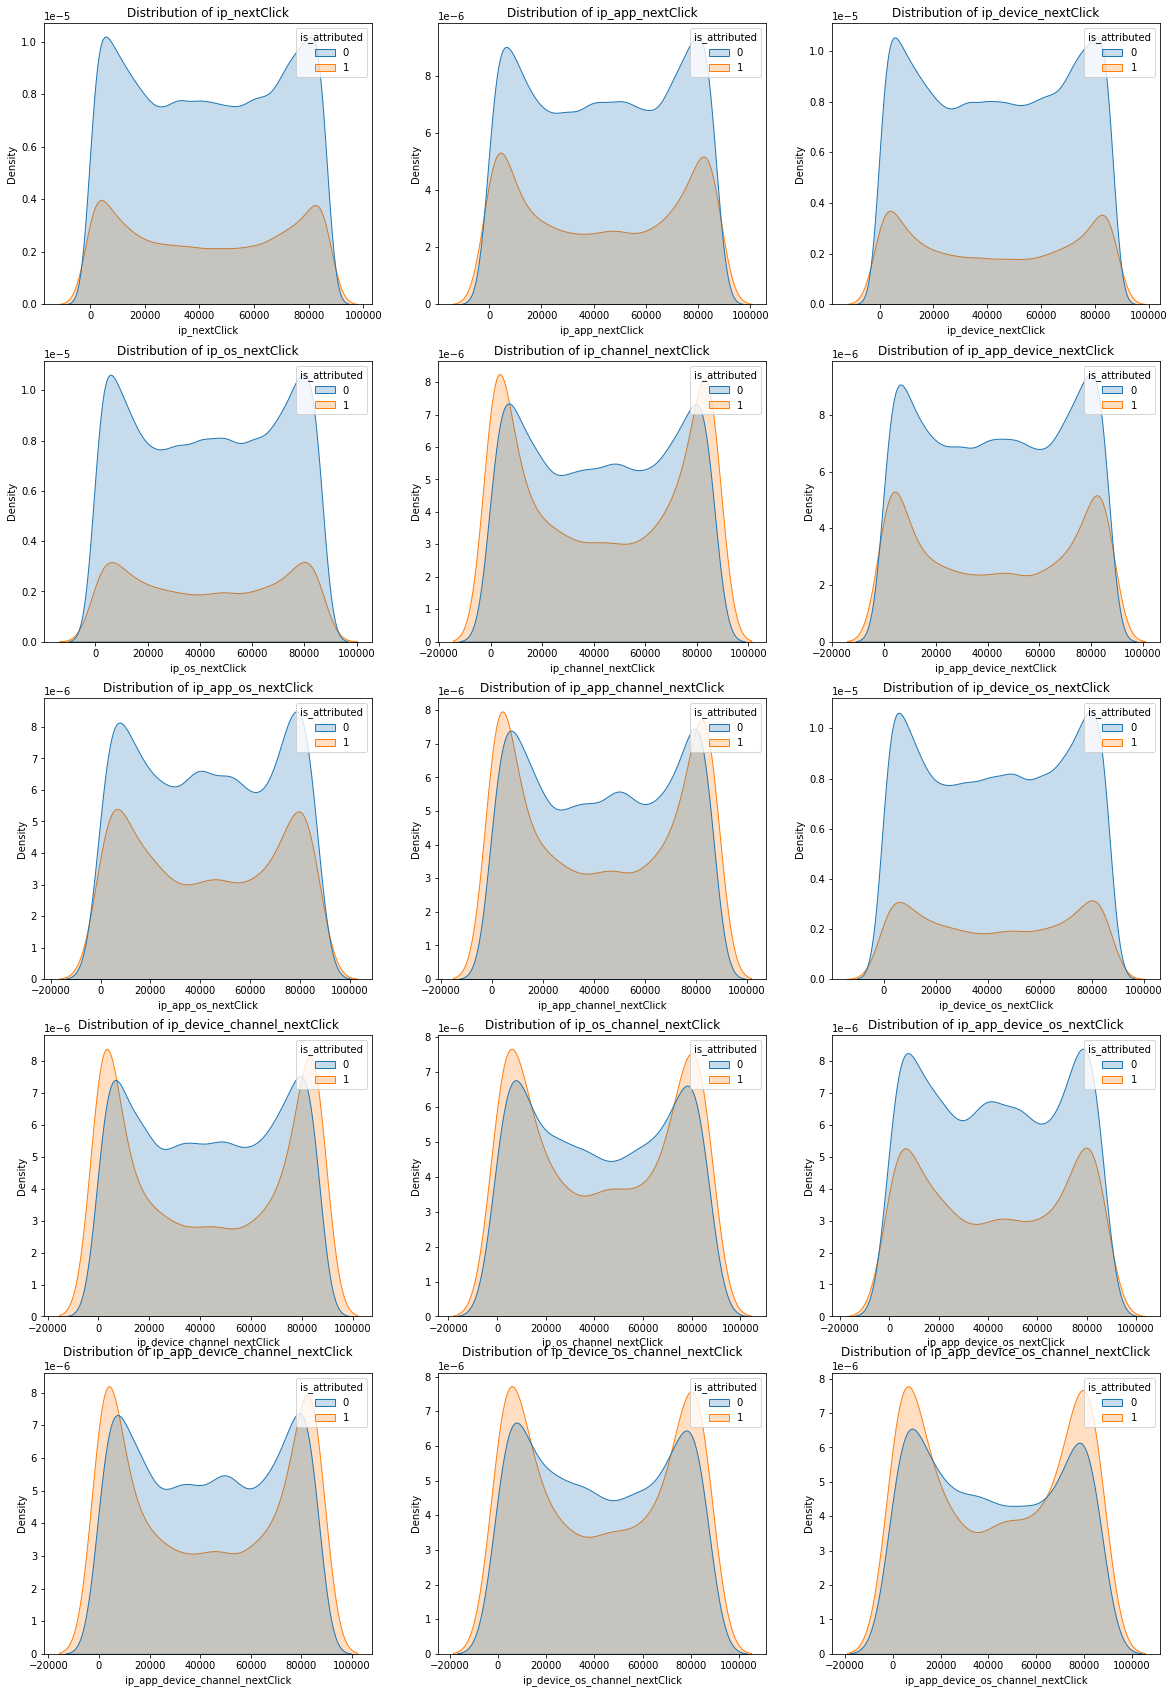

In [65]:
#density plots get array of labels

plt.figure(figsize=(20, 30))
for index, var in enumerate(train.columns[11:]):
  plt.subplot(5, 3, index+1)
  sns.kdeplot(data=train, x=var, hue="is_attributed", fill=True)
  plt.title(f"Distribution of {var}")

plt.show()

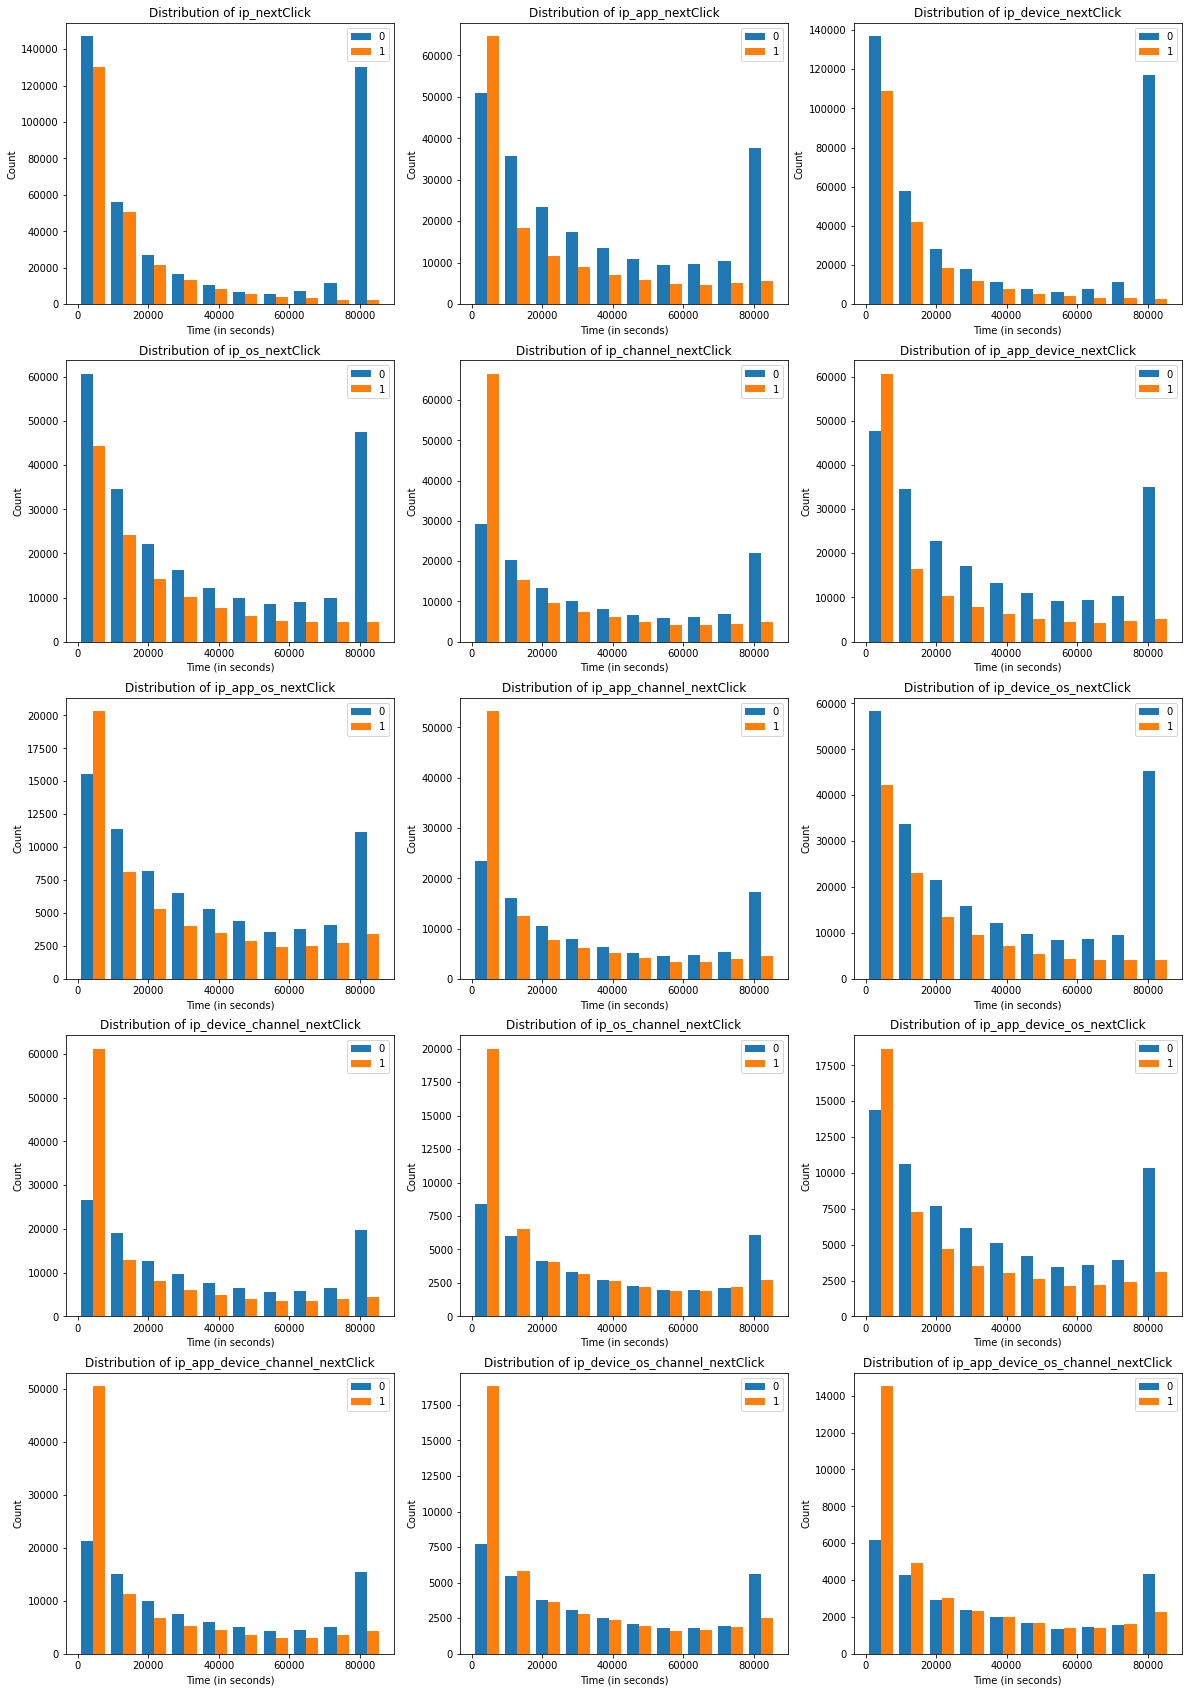

In [ ]:
# plt.figure(figsize=(20, 30))
# for index, var in enumerate(train.columns[11:26]):
#   plt.subplot(5, 3, index+1)
#   var_0 = train[train['is_attributed']==0][var]
#   var_1 = train[train['is_attributed']==1][var]
#   plt.hist([var_0, var_1], label=["0", "1"])
#   plt.legend(loc="best")
#   plt.ylabel('Count')
#   plt.xlabel('Time (in seconds)')
#   plt.title(f"Distribution of {var}")

# plt.show()

In [ ]:
## for normal entries, they peak when the time btw clicks is ard 0s
## on the other hand for fraud entries, they when the time btw clicks is ard 0s and 80000s (ard 1 day)

215131

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BT4012/dataset/train_FE5.csv')

In [ ]:
plt.figure(figsize=(20, 30))
for index, var in enumerate(data.columns[11:26]):
  plt.subplot(5, 3, index+1)
  sns.kdeplot(data=data, x=var, hue="is_attributed", fill=True)
  plt.title(f"Distribution of {var}")

plt.show()

##  Clicks on app ad before & after

In [259]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    train['prev_'+fname] = train.groupby(fset).cumcount().rename('prev_'+fname)
        
    # Clicks in the future
    train['future_'+fname] = train.iloc[::-1].groupby(fset).cumcount().rename('future_'+fname).iloc[::-1]
 
train.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,ip_device_channel_nextClick,ip_os_channel_nextClick,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_device_os_channel_nextClick,ip_app_device_os_channel_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,59605.0,NaN,NaN,59605.0,NaN,NaN,0,0,0,3
1,92610,3,1,13,280,2017-11-07 03:06:29,0,7,3,6,...,NaN,NaN,10969.0,NaN,NaN,NaN,0,0,0,1
2,79894,2,1,19,122,2017-11-07 11:15:24,0,7,11,15,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,32746,3,1,31,480,2017-11-08 14:44:58,0,8,14,44,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
4,1638,2,1,20,236,2017-11-09 10:24:38,0,9,10,24,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1


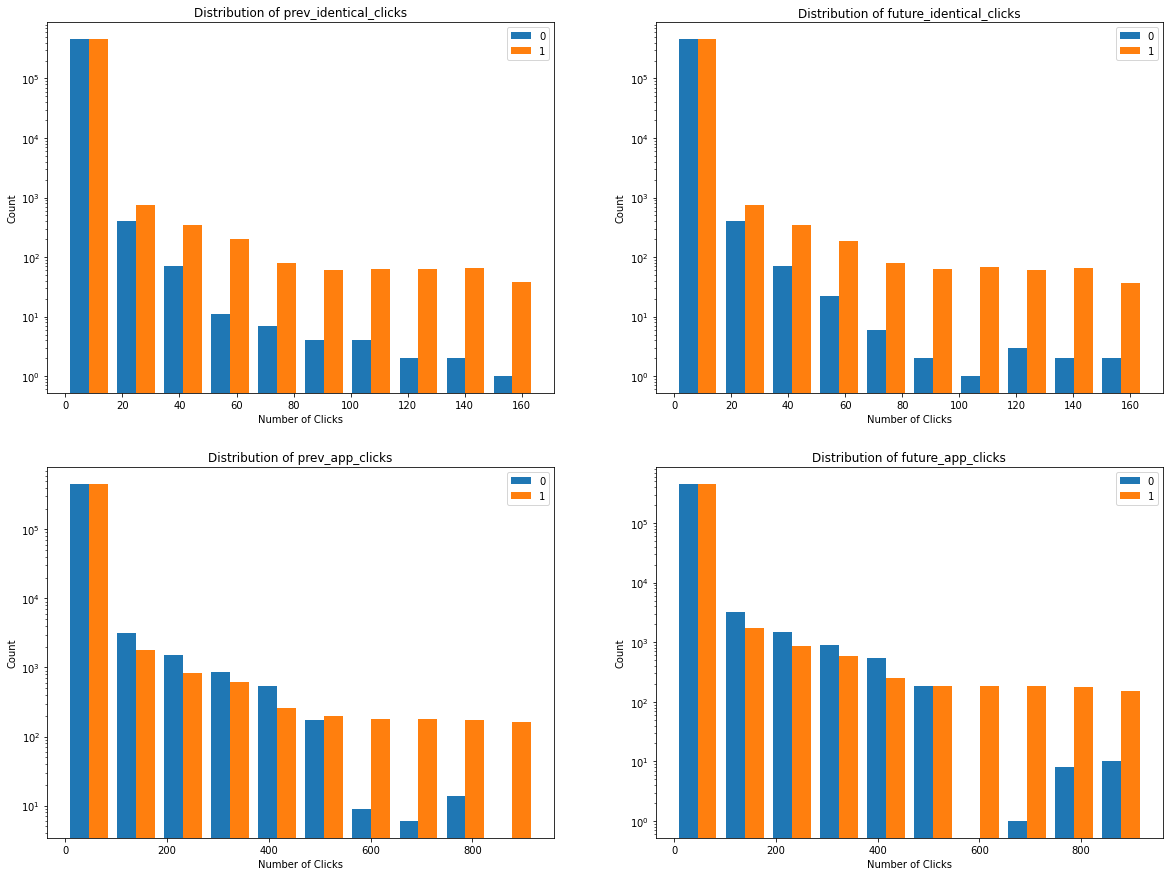

In [ ]:
# plt.figure(figsize=(20, 15))
# for index, var in enumerate(train.columns[26:30]):
#   plt.subplot(2, 2, index+1)
#   var_0 = train[train['is_attributed']==0][var]
#   var_1 = train[train['is_attributed']==1][var]
#   plt.hist([var_0, var_1], label=["0", "1"])
#   plt.legend(loc="best")
#   plt.yscale("log")
#   plt.ylabel('Count')
#   plt.xlabel('Number of Clicks')
#   plt.title(f"Distribution of {var}")

# plt.show()

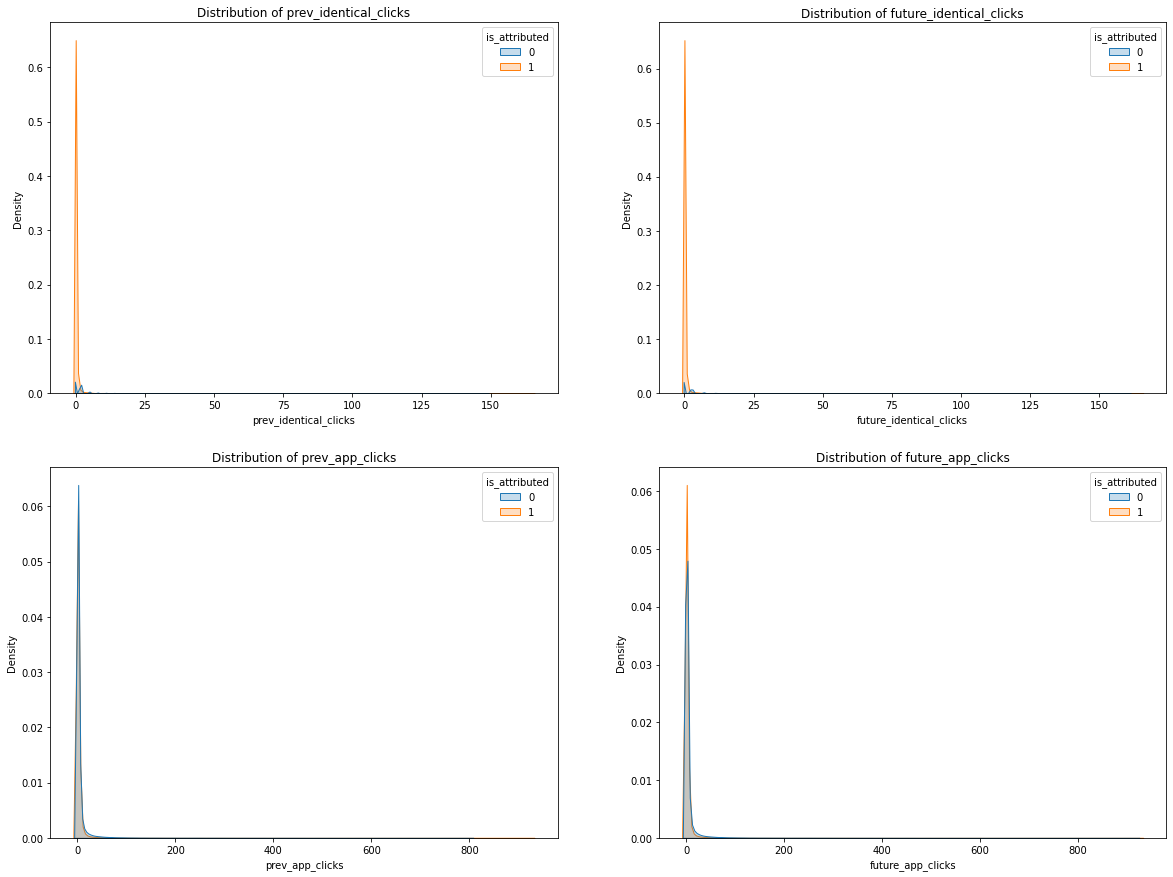

In [ ]:
plt.figure(figsize=(20, 15))
for index, var in enumerate(data.columns[26:30]):
  plt.subplot(2, 2, index+1)
  sns.kdeplot(data=data, x=var, hue="is_attributed", fill=True)
  plt.title(f"Distribution of {var}")

plt.show()

## Confidence Rates for is_attributed

In [260]:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # V2 Features #
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(10**6) # 1000 views -> 50% confidence, 100 views -> 33% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}.".format(cols, new_feature))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    train = train.merge(
        group_object['is_attributed'].apply(rate_calculation).reset_index().
        rename(index=str,columns={'is_attributed': new_feature})[cols + [new_feature]],
        on=cols, how='left'
    )
    
train.head()

>> Calculating confidence-weighted rate for: ['ip'].
   Saving to: ip_confRate.
>> Calculating confidence-weighted rate for: ['app'].
   Saving to: app_confRate.
>> Calculating confidence-weighted rate for: ['device'].
   Saving to: device_confRate.
>> Calculating confidence-weighted rate for: ['os'].
   Saving to: os_confRate.
>> Calculating confidence-weighted rate for: ['channel'].
   Saving to: channel_confRate.
>> Calculating confidence-weighted rate for: ['app', 'channel'].
   Saving to: app_channel_confRate.
>> Calculating confidence-weighted rate for: ['app', 'os'].
   Saving to: app_os_confRate.
>> Calculating confidence-weighted rate for: ['app', 'device'].
   Saving to: app_device_confRate.
>> Calculating confidence-weighted rate for: ['channel', 'os'].
   Saving to: channel_os_confRate.
>> Calculating confidence-weighted rate for: ['channel', 'device'].
   Saving to: channel_device_confRate.
>> Calculating confidence-weighted rate for: ['os', 'device'].
   Saving to: os_dev

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,app_confRate,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,0.051893,0.358049,0.155254,0.022429,0.025245,0.000000,0.053586,0.000000,0.023461,0.157936
1,92610,3,1,13,280,2017-11-07 03:06:29,0,7,3,6,...,0.076292,0.358049,0.288087,0.063045,0.053648,0.059310,0.077493,0.051676,0.064268,0.292719
2,79894,2,1,19,122,2017-11-07 11:15:24,0,7,11,15,...,0.065913,0.358049,0.322458,0.090301,0.059503,0.069368,0.068332,0.091254,0.093129,0.325176
3,32746,3,1,31,480,2017-11-08 14:44:58,0,8,14,44,...,0.076292,0.358049,0.156693,0.042289,0.039638,0.017383,0.077493,0.000000,0.042177,0.158367
4,1638,2,1,20,236,2017-11-09 10:24:38,0,9,10,24,...,0.065913,0.358049,0.199521,0.054623,0.054623,0.022488,0.068332,0.011217,0.054977,0.204446


In [ ]:
plt.figure(figsize=(20, 30))
for index, var in enumerate(train.columns[40:]):
  plt.subplot(6, 2, index+1)
  plt.scatter(x="ip", y=var, data=train[train['is_attributed']==1], color="orange", alpha=0.1)
  plt.scatter(x="ip", y=var, data=train[train['is_attributed']==0], color="blue", alpha=0.1)
  plt.legend(["1", "0"], loc="best")
  plt.ylabel('Confidence Rate')
  plt.xlabel('IP')
  plt.title(f"Distribution of {var}")

plt.show()

## Combining device & IP

In [263]:
train['device_ip'] = train['device'].map(str) + train['ip'].map(str)
train.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate,device_ip
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,0.358049,0.155254,0.022429,0.025245,0.000000,0.053586,0.000000,0.023461,0.157936,1116992
1,92610,3,1,13,280,2017-11-07 03:06:29,0,7,3,6,...,0.358049,0.288087,0.063045,0.053648,0.059310,0.077493,0.051676,0.064268,0.292719,192610
2,79894,2,1,19,122,2017-11-07 11:15:24,0,7,11,15,...,0.358049,0.322458,0.090301,0.059503,0.069368,0.068332,0.091254,0.093129,0.325176,179894
3,32746,3,1,31,480,2017-11-08 14:44:58,0,8,14,44,...,0.358049,0.156693,0.042289,0.039638,0.017383,0.077493,0.000000,0.042177,0.158367,132746
4,1638,2,1,20,236,2017-11-09 10:24:38,0,9,10,24,...,0.358049,0.199521,0.054623,0.054623,0.022488,0.068332,0.011217,0.054977,0.204446,11638


In [264]:
device_ip_1 = train[train['is_attributed'] == 1]['device_ip']
device_ip_0 = train[train['is_attributed'] == 0]['device_ip']

set_device_ip_1 = set(device_ip_1.unique())
set_device_ip_0 = set(device_ip_0.unique())

print('No. of unique device_ip that downloaded app:', len(set_device_ip_1))
print('No. of unique device_ip that did not download app:', len(set_device_ip_0))

No. of unique device_ip that downloaded app: 72740
No. of unique device_ip that did not download app: 35883


In [265]:
# device_ip that always download app after clicking
device_ip_download = set_device_ip_1.difference(set_device_ip_0)

# device_ip that always do not download app after clicking
device_ip_fraud = set_device_ip_0.difference(set_device_ip_1)

print('No. of device_ip that ALWAYS downloaded app:', len(device_ip_download))
print('No. of device_ip that NEVER downloaded app:', len(device_ip_fraud))

No. of device_ip that ALWAYS downloaded app: 59913
No. of device_ip that NEVER downloaded app: 23056


In [266]:
pct_device_ip_download = (len(device_ip_download) / len(set_device_ip_1))*100
pct_device_ip_fraud = (len(device_ip_fraud) / len(set_device_ip_0))*100

print('Percentage of device_ip that ALWAYS downloaded app:', round(pct_device_ip_download, 2), '%')
print('Percentage of device_ip that NEVER downloaded app:', round(pct_device_ip_fraud, 2), '%')

Percentage of device_ip that ALWAYS downloaded app: 82.37 %
Percentage of device_ip that NEVER downloaded app: 64.25 %


## Combining device & hour

In [267]:
train_hour_0 = train[train["is_attributed"] == 0]['hour']
train_hour_1 = train[train["is_attributed"] == 1]['hour']

In [268]:
train['device_hour'] = train['device'].map(str) + train['hour'].map(str)
train.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate,device_ip,device_hour
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,0.155254,0.022429,0.025245,0.000000,0.053586,0.000000,0.023461,0.157936,1116992,16
1,92610,3,1,13,280,2017-11-07 03:06:29,0,7,3,6,...,0.288087,0.063045,0.053648,0.059310,0.077493,0.051676,0.064268,0.292719,192610,13
2,79894,2,1,19,122,2017-11-07 11:15:24,0,7,11,15,...,0.322458,0.090301,0.059503,0.069368,0.068332,0.091254,0.093129,0.325176,179894,111
3,32746,3,1,31,480,2017-11-08 14:44:58,0,8,14,44,...,0.156693,0.042289,0.039638,0.017383,0.077493,0.000000,0.042177,0.158367,132746,114
4,1638,2,1,20,236,2017-11-09 10:24:38,0,9,10,24,...,0.199521,0.054623,0.054623,0.022488,0.068332,0.011217,0.054977,0.204446,11638,110


In [269]:
device_hour_1 = train[train['is_attributed'] == 1]['device_hour']
device_hour_0 = train[train['is_attributed'] == 0]['device_hour']

set_device_hour_1 = set(device_hour_1.unique())
set_device_hour_0 = set(device_hour_0.unique())

print('No. of unique device_hour that downloaded app:', len(set_device_hour_1))
print('No. of unique device_hour that did not download app:', len(set_device_hour_0))

No. of unique device_hour that downloaded app: 3834
No. of unique device_hour that did not download app: 259


In [270]:
# device_hour that always download app after clicking
device_hour_download = set_device_hour_1.difference(set_device_hour_0)

# device_hour that always do not download app after clicking
device_hour_fraud = set_device_hour_0.difference(set_device_hour_1)

print('No. of device_hour that ALWAYS downloaded app:', len(device_hour_download))
print('No. of device_hour that NEVER downloaded app:', len(device_hour_fraud))

No. of device_hour that ALWAYS downloaded app: 3684
No. of device_hour that NEVER downloaded app: 109


In [271]:
pct_device_hour_download = (len(device_hour_download) / len(set_device_hour_1))*100
pct_device_hour_fraud = (len(device_hour_fraud) / len(set_device_hour_0))*100

print('Percentage of device_hour that ALWAYS downloaded app:', round(pct_device_hour_download, 2), '%')
print('Percentage of device_hour that NEVER downloaded app:', round(pct_device_hour_fraud, 2), '%')

Percentage of device_hour that ALWAYS downloaded app: 96.09 %
Percentage of device_hour that NEVER downloaded app: 42.08 %


### Channel, device, and dateTime conversion rate

In [272]:
train = pd.merge(train,conversion_rate_channel[['channel','conversion_rate']],on='channel')
train.rename({'conversion_rate': 'channel_conversion_rate'}, axis=1, inplace=True)
train = pd.merge(train,conversion_rate_device[['device','conversion_rate']],on='device')
train.rename({'conversion_rate': 'device_conversion_rate'}, axis=1, inplace=True)
conversion_rate_time = conversion_rate_time.reset_index(level=0)
train = pd.merge(train,conversion_rate_time[['dateTime','conversion_rate']],on='dateTime')
train.rename({'conversion_rate': 'dateTime_conversion_rate'}, axis=1, inplace=True)

In [273]:
##save the generated features
train.to_csv('./train_FE5.csv', index=False)

## Response Coding for Categorical Variables

In [70]:
from tqdm import tqdm

# what is alpha
def get_feature_dict(alpha, feature, df):
  value_count = train[feature].value_counts()
  feature_dict = dict()
  value_count_items = value_count.items()

  class_0 = train['is_attributed'] == 0
  class_1 = train['is_attributed'] == 1

  for i, denominator in tqdm(value_count_items):
    b = train[feature] == i
    vec = []

    for k in range(2):
      if k == 0:
        cls_cnt = train.loc[class_0 & b]
      else:
        cls_cnt = train.loc[class_1 & b]
      
      vec.append((cls_cnt.shape[0] + 10*alpha)/ (denominator + 20*alpha))
    
    feature_dict[i] = vec
  
  return feature_dict



def get_feature(alpha, feature, df, feature_dict):
  value_count = train[feature].value_counts()
  value_count_keys = dict(value_count).keys()
  
  feature = []
  for index, row in tqdm(df.iterrows()):
    if row[feature] in value_count_keys:
      feature.append(feature_dict[row[feature]])
    
    else:
      feature.append([1/2, 1/2])
  
  return feature

# Data Processing after new features generated

<p>Drop click_date and dateTime since they are redundant information</p>

In [34]:
data = data.drop(['click_date', 'dateTime'], axis = 1)

Deal with NaN values

In [35]:
checkna = [data[var].isnull().sum() for var in data.columns]
na_df = pd.DataFrame({"Variable": data.columns, "Number of Missing Values": checkna})

In [36]:
na_df[na_df["Number of Missing Values"] > 0]

,Variable,Number of Missing Values
36,var_hour_by_ip_app_channel,157117
37,var_hour_by_ip_app_os,169616
38,var_hour_by_ip_app_device,136110
39,var_day_by_ip_app_channel,157117
40,var_day_by_ip_app_os,169616
41,var_day_by_ip_app_device,136110
45,ip_nextClick,84781
46,ip_app_nextClick,150549
47,ip_device_nextClick,95806
48,ip_os_nextClick,147780


Variables with the naming convention "var_variable_by_variablegroup" represent the variance of $variable$ among $variablegroup$. It has NaN values when there is only one value in $variablegroup$. To deal with such missing values, we can set the NaN values to be 0, meaning that there is no variance for $variable$ among $variablegroup$.

Variables with the naming convention "variablegroup_nextClick" represent the time till next click between items in $variablegroup$. It has NaN values when there is no click after the current one in the $variablegroup$. We can interpret such variables as has_nextClick * time_till_nextClick, where has_nextClick takes 0 when there is no next click and 1 otherwise. Therefore, we can then set the NaN values to be 0.

In [37]:
data.fillna(0, inplace=True)

In [38]:
checkna1 = [data[var].isnull().sum() for var in data.columns]
na_df1 = pd.DataFrame({"Variable": data.columns, "Number of Missing Values": checkna1})
len(na_df1[na_df1["Number of Missing Values"] > 0])

0

In [38]:
data = pd.read_csv("./train_FE_processed.csv")

In [40]:
data = data.drop(labels = ['channel_conversion_rate', 'device_conversion_rate',
       'dateTime_conversion_rate'], axis = 1)

In [42]:
data = data.drop(labels = ['ip_confRate', 'app_confRate', 'device_confRate', 'os_confRate',
       'channel_confRate', 'app_channel_confRate', 'app_os_confRate',
       'app_device_confRate', 'channel_os_confRate', 'channel_device_confRate',
       'os_device_confRate'], axis = 1)

In [50]:
##save the data after processing
data.to_csv('./train_FE_processed.csv', index=False)

# Feature Selection

In [3]:
#Import data
train = pd.read_csv("./train_FE_processed.csv")
train.head(3)

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_device_os_channel_nextClick,ip_app_device_os_channel_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks,device_ip,device_hour
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,0.0,59605.0,0.0,0.0,0,0,0,3,1116992,16
1,136145,12,1,22,245,2017-11-07 06:10:42,0,7,6,10,...,0.0,0.0,0.0,0.0,0,0,0,0,1136145,16
2,32371,15,1,11,245,2017-11-07 06:51:41,0,7,6,51,...,0.0,0.0,0.0,0.0,0,0,0,0,132371,16


In [6]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'day', 'hour', 'minute', 'second', 'dayOfWeek',
       'ip_app_dev_os_cha_counts', 'ip_app_dev_os_counts', 'ip_app_dev_counts',
       'ip_app_os_counts', 'ip_app_hour_counts', 'ip_channel_counts',
       'ip_app_counts', 'ip_per_day', 'ip_counts', 'uniq_app_per_ip',
       'uniq_device_per_ip', 'uniq_channel_per_ip', 'uniq_os_per_ip',
       'uniq_app_per_ip_dev_os', 'uniq_channel_per_app',
       'uniq_hour_per_ip_day', 'uniq_os_per_ip_app', 'cum_count_by_ip',
       'cum_count_by_ip_device', 'cum_count_by_ip_device_os',
       'cum_count_by_ip_device_os_channel',
       'cum_count_by_ip_device_os_channel_app', 'cum_count_by_app',
       'cum_count_by_ip_app', 'var_hour_by_ip_app_channel',
       'var_hour_by_ip_app_os', 'var_hour_by_ip_app_device',
       'var_day_by_ip_app_channel', 'var_day_by_ip_app_os',
       'var_day_by_ip_app_device', 'mean_hour_by_ip_app_channel',
       'mean_hour_by_ip_app

In [4]:
X_train = train.drop(labels = 'is_attributed', axis = 1)
Y_train = train["is_attributed"]

In [275]:
X_train.dtypes

ip                            int64
app                           int64
device                        int64
os                            int64
channel                       int64
                             ...   
device_ip                    object
device_hour                  object
channel_conversion_rate     float64
device_conversion_rate      float64
dateTime_conversion_rate    float64
Length: 81, dtype: object

## Check correlation between features

In [8]:
X_categorical = ['ip', 'app', 'device', 'os', 'channel', 'day', 'dayOfWeek', 'device_ip', 'device_hour']
X_numerical = ['click_time', 'hour', 'minute', 'second',
       'ip_app_dev_os_cha_counts', 'ip_app_dev_os_counts', 'ip_app_dev_counts',
       'ip_app_os_counts', 'ip_app_hour_counts', 'ip_channel_counts',
       'ip_app_counts', 'ip_per_day', 'ip_counts', 'uniq_app_per_ip',
       'uniq_device_per_ip', 'uniq_channel_per_ip', 'uniq_os_per_ip',
       'uniq_app_per_ip_dev_os', 'uniq_channel_per_app',
       'uniq_hour_per_ip_day', 'uniq_os_per_ip_app', 'cum_count_by_ip',
       'cum_count_by_ip_device', 'cum_count_by_ip_device_os',
       'cum_count_by_ip_device_os_channel',
       'cum_count_by_ip_device_os_channel_app', 'cum_count_by_app',
       'cum_count_by_ip_app', 'var_hour_by_ip_app_channel',
       'var_hour_by_ip_app_os', 'var_hour_by_ip_app_device',
       'var_day_by_ip_app_channel', 'var_day_by_ip_app_os',
       'var_day_by_ip_app_device', 'mean_hour_by_ip_app_channel',
       'mean_hour_by_ip_app_os', 'mean_hour_by_ip_app_device', 'ip_nextClick',
       'ip_app_nextClick', 'ip_device_nextClick', 'ip_os_nextClick',
       'ip_channel_nextClick', 'ip_app_device_nextClick',
       'ip_app_os_nextClick', 'ip_app_channel_nextClick',
       'ip_device_os_nextClick', 'ip_device_channel_nextClick',
       'ip_os_channel_nextClick', 'ip_app_device_os_nextClick',
       'ip_app_device_channel_nextClick', 'ip_device_os_channel_nextClick',
       'ip_app_device_os_channel_nextClick', 'prev_identical_clicks',
       'future_identical_clicks', 'prev_app_clicks', 'future_app_clicks']
X_train_categorical = X_train[X_categorical]
X_train_numerical = X_train[X_numerical]

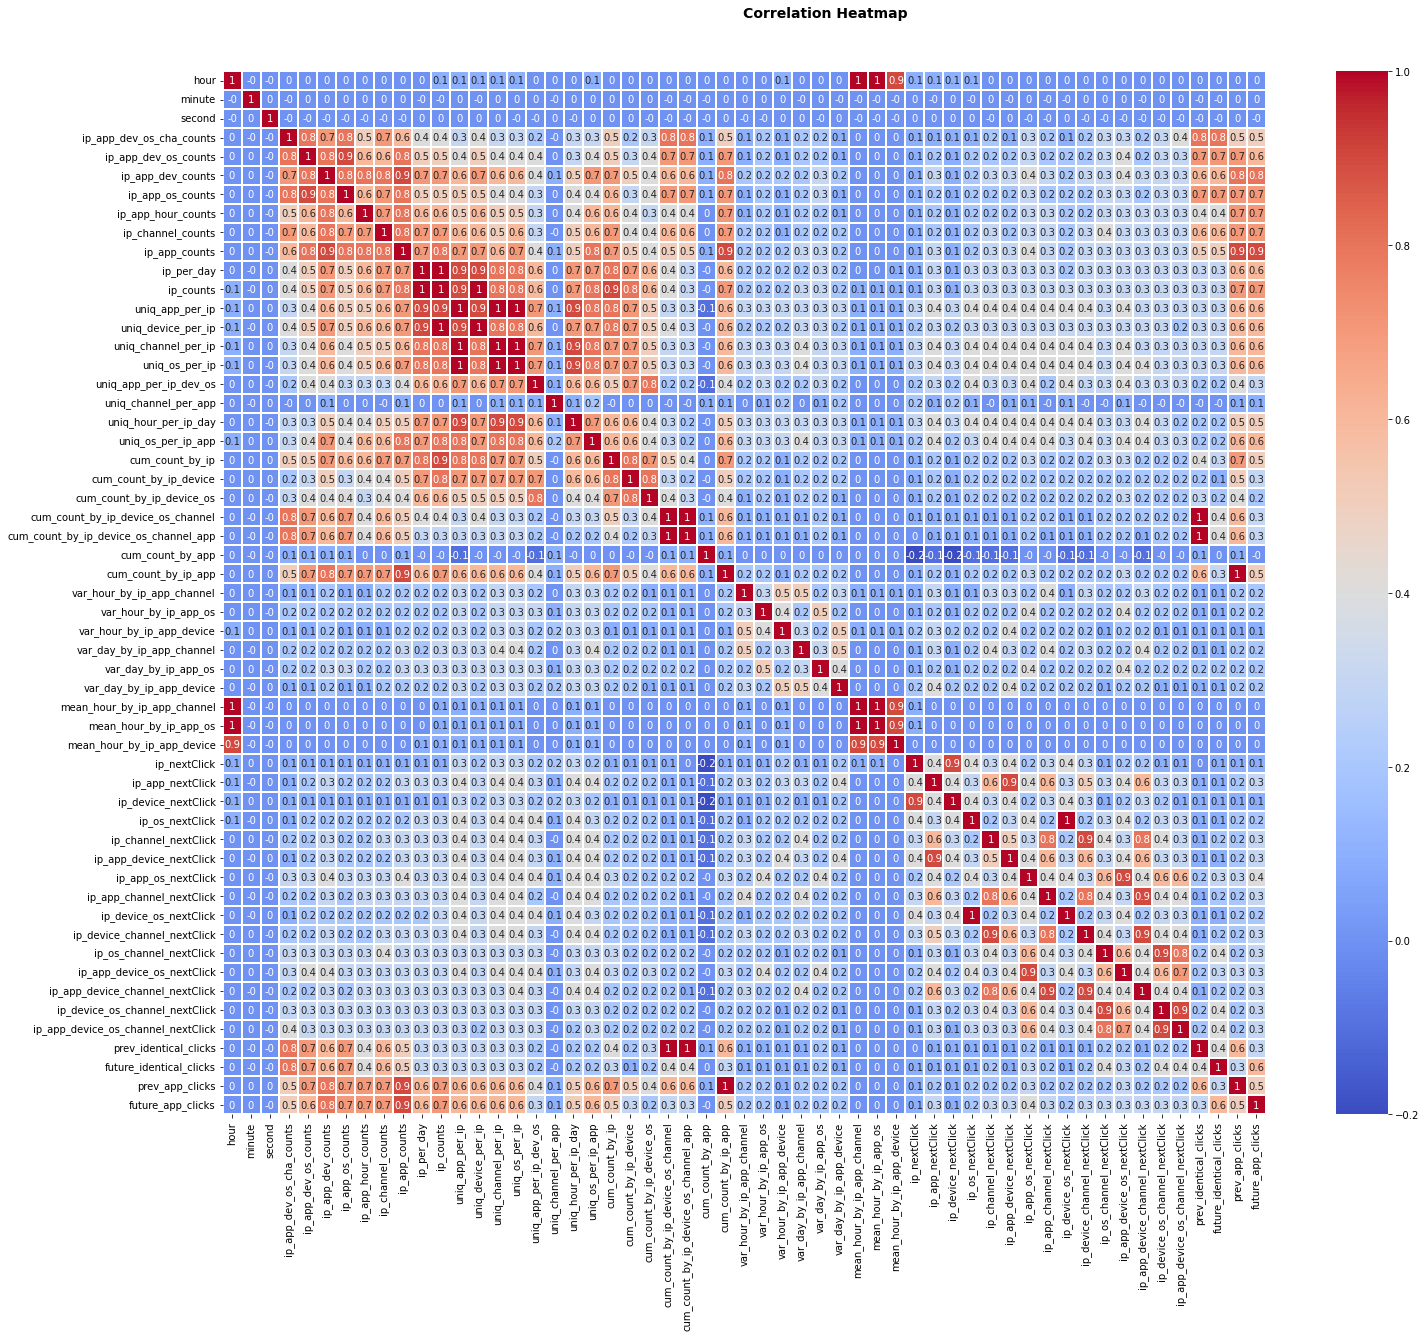

In [16]:
fig, ax = plt.subplots(1,1, figsize=(25,18))

hm = sns.heatmap(round(X_train_numerical.corr(),1), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 square=True, # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 #annot_kws={"size": 14},
                 linewidths=0.1)

fig.subplots_adjust(top=0.93)

t = fig.suptitle('Correlation Heatmap', fontsize=14, fontweight='bold')

In [17]:
c = X_train_numerical.corr().abs()

s = c.unstack()
so = s.sort_values(ascending = False)
so

hour                      hour                        1.000000
second                    second                      1.000000
cum_count_by_ip_app       prev_app_clicks             1.000000
                          cum_count_by_ip_app         1.000000
cum_count_by_app          cum_count_by_app            1.000000
                                                        ...   
uniq_app_per_ip_dev_os    second                      0.000060
uniq_channel_per_app      ip_app_channel_nextClick    0.000032
ip_app_channel_nextClick  uniq_channel_per_app        0.000032
second                    uniq_os_per_ip              0.000031
uniq_os_per_ip            second                      0.000031
Length: 3025, dtype: float64

Since click_time, device_ip and device_hour are categorical type, these categorical features should be encoded.

In [280]:
label = preprocessing.LabelEncoder()
X_train['click_time'] = label.fit_transform(X_train['click_time'].astype(str))
X_train['device_ip'] = label.fit_transform(X_train['device_ip'].astype(str))
X_train['device_hour'] = label.fit_transform(X_train['device_hour'].astype(str))

### 1. XGBoost Classifier 

In [242]:
xgb_model = XGBClassifier(random_state = 0)
xgb_model.fit(X_train, Y_train)
Y_train_pred = xgb_model.predict(X_train)

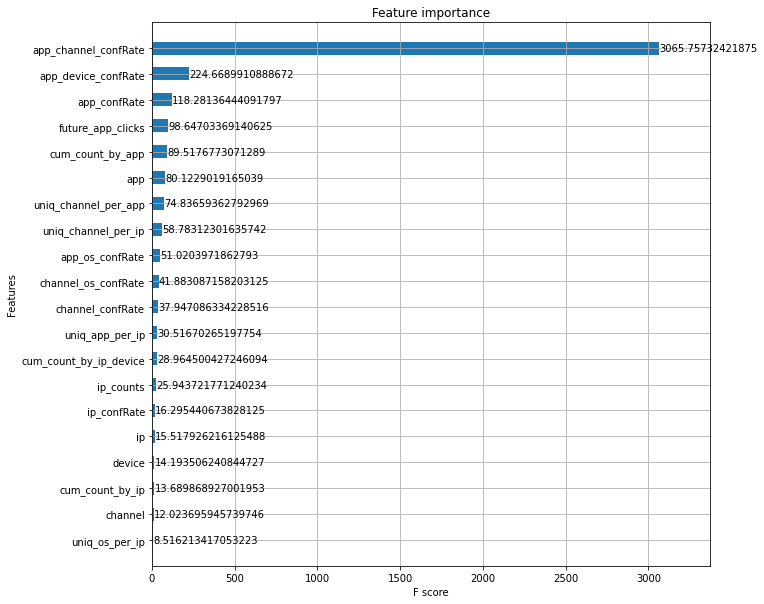

In [246]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(xgb_model, max_num_features = 20, height = 0.5, ax = ax,
                importance_type = "gain")
plt.show()

In [250]:
top_features = pd.DataFrame()
top_features['feature'] = X_train.columns
top_features['importance'] = xgb_model.feature_importances_
top_features.sort_values(by = 'importance', ascending=False, inplace=True)

top20_XGB_features = top_features[:20]
top20_XGB_features

,feature,importance
50,app_channel_confRate,0.736667
52,app_device_confRate,0.053985
46,app_confRate,0.028422
44,future_app_clicks,0.023704
30,cum_count_by_app,0.021510
1,app,0.019253
22,uniq_channel_per_app,0.017982
19,uniq_channel_per_ip,0.014125
51,app_os_confRate,0.012260
53,channel_os_confRate,0.010064


### 2. LightGBM

In [283]:
#lightGBM model fit
gbm = lgb.LGBMRegressor()
gbm.fit(X_train, Y_train)
gbm.booster_.feature_importance()

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols':X_train.columns, 'fea_imp':gbm.feature_importances_})
top20_features = fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False).head(20)
top20_features

,cols,fea_imp
33,cum_count_by_app,736
1,app,346
64,app_confRate,207
25,uniq_channel_per_app,165
68,app_channel_confRate,162
44,ip_nextClick,145
19,ip_counts,129
63,ip_confRate,122
69,app_os_confRate,122
28,cum_count_by_ip,119


# Model Building

The following models will be evaluated for this classification problem:
1. Logistic Regression
2. K Nearest Neighbours (KNN)
3. Support Vector Classifier
4. Random Forest Classifier
5. XGBoost Classifier

In [2]:
#import relevant libraries
import pandas as pd

#Log Reg
from sklearn.linear_model import LogisticRegression

# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

# SVM Classifier
from sklearn.svm import SVC

#Neural Network
from keras.models import Sequential
from keras.layers import Dense

#tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [3]:
from sklearn import metrics

def evaluation_metrics(y_actual, y_pred):
    # Confusion matrix
    print('Confusion matrix:\n', metrics.confusion_matrix(y_actual, y_pred), '\n')
    
    # Accuracy
    print('Accuracy:', metrics.accuracy_score(y_actual, y_pred), '\n')
    
    # Precision
    print('Precision:', metrics.precision_score(y_actual, y_pred), '\n')
    
    # Recall
    print('Recall:', metrics.recall_score(y_actual, y_pred))

In [4]:
#Import data with the generated features
data = pd.read_csv("./train_FE_processed.csv")
data.head(3)

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate,device_ip,device_hour,channel_conversion_rate,device_conversion_rate,dateTime_conversion_rate
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,0.000000,0.053586,0.000000,0.023461,0.157936,1116992,16,0.0368,0.414982,0.516346
1,136145,12,1,22,245,2017-11-07 06:10:42,0,7,6,10,...,0.032172,0.029720,0.025995,0.023461,0.259173,1136145,16,0.0368,0.414982,0.516346
2,32371,15,1,11,245,2017-11-07 06:51:41,0,7,6,51,...,0.052964,0.053586,0.000000,0.023461,0.374908,132371,16,0.0368,0.414982,0.516346


In [6]:
#top 20 xgb features
xgb = ["app_channel_confRate", "app_device_confRate", "app_confRate", "future_app_clicks", "cum_count_by_app", "app", "uniq_channel_per_app",
"uniq_channel_per_ip",	"app_os_confRate",	"channel_os_confRate", "channel_confRate", 	"uniq_app_per_ip", "cum_count_by_ip_device", "ip_counts", "ip_confRate", "ip", "device", "cum_count_by_ip", 
"channel", "uniq_os_per_ip"]

In [7]:
#top 20 lgb features
lgb_features = ["cum_count_by_app", "app", "app_confRate","uniq_channel_per_app","app_channel_confRate","ip_nextClick","ip_counts","ip_confRate","app_os_confRate", "cum_count_by_ip", "channel_os_confRate", "app_device_confRate", "channel_conversion_rate", "cum_count_by_ip_device", "channel_confRate", "channel", "ip", "channel_device_confRate", "ip_device_nextClick",	"uniq_os_per_ip"]

### Preprocessing 

(Decision Trees Algo Dont Need)
- One hot encoding?
- Normalisation/Standardisation?

In [8]:
#do on xgb first
X_train_xgb = data[xgb]
y_train = data["is_attributed"]

In [9]:
X_train_xgb.dtypes

app_channel_confRate      float64
app_device_confRate       float64
app_confRate              float64
future_app_clicks           int64
cum_count_by_app            int64
app                         int64
uniq_channel_per_app        int64
uniq_channel_per_ip         int64
app_os_confRate           float64
channel_os_confRate       float64
channel_confRate          float64
uniq_app_per_ip             int64
cum_count_by_ip_device      int64
ip_counts                   int64
ip_confRate               float64
ip                          int64
device                      int64
cum_count_by_ip             int64
channel                     int64
uniq_os_per_ip              int64
dtype: object

In [10]:
cat = ["app", "ip", "device", "channel"]
X_num = X_train_xgb.drop(labels=cat, axis=1)
X_cat = X_train_xgb[cat]

In [11]:
#Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
X_train_xgb_scaled = pd.DataFrame(X_num_scaled, index = X_num.index, columns = X_num.columns)
X_train_xgb_scaled.head()
#testing: scaler.transform(test)

,app_channel_confRate,app_device_confRate,app_confRate,future_app_clicks,cum_count_by_app,uniq_channel_per_app,uniq_channel_per_ip,app_os_confRate,channel_os_confRate,channel_confRate,uniq_app_per_ip,cum_count_by_ip_device,ip_counts,ip_confRate,cum_count_by_ip,uniq_os_per_ip
0,-0.968603,-0.909824,-0.957593,0.254066,-0.985818,0.893334,-0.058315,-1.042871,-1.025895,-1.034998,-0.035584,-0.184895,-0.149321,-0.814234,-0.187034,0.150383
1,-1.015386,-0.999577,-1.041095,-0.157594,-0.976227,1.145415,-0.481069,-0.903997,-0.909416,-1.034998,-0.539007,-0.184895,-0.217328,-0.814234,-0.187034,-0.528933
2,-0.968603,-0.909824,-0.957593,-0.157594,-0.967645,0.893334,-0.360282,-0.814242,-1.025895,-1.034998,-0.337638,-0.184895,-0.202215,-0.814234,-0.187034,-0.431888
3,-0.968603,-0.909824,-0.957593,-0.157594,-0.965121,0.893334,-0.481069,-0.814242,-1.025895,-1.034998,-0.539007,-0.184895,-0.217328,-0.814234,-0.187034,-0.528933
4,-0.968603,-0.909824,-0.957593,-0.157594,-0.901684,0.893334,-0.420675,-1.006143,-0.924123,-1.034998,-0.438322,-0.184895,-0.202215,0.371996,-0.187034,-0.334843


In [10]:
#One hot encoding (might be too large, thinking if we should drop these variables in prediction. e.g. ip in test set may not be in train set thus useless)

#can use label enconding but concern is that the numeric values can be misinterpreted by algorithms as having some sort of hierarchy/order in them

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
#very large matrix with lots of col
enc.fit_transform(X_cat)

<186454x86151 sparse matrix of type '<class 'numpy.float64'>'
	with 745816 stored elements in Compressed Sparse Row format>

### Logistic Regression

Baseline

In [12]:
lr = LogisticRegression(random_state=0, max_iter = 2000)

lr.fit(X_train_xgb_scaled, y_train)
y_train_pred_lr = lr.predict(X_train_xgb_scaled)

In [13]:
evaluation_metrics(y_train,y_train_pred_lr)

Confusion matrix:
 [[90100  3127]
 [ 5917 87310]] 

Accuracy: 0.9514947386486747 

Precision: 0.9654234439444033 

Recall: 0.9365312624025228


Tuned model

In [14]:
lr = LogisticRegression(random_state=0, max_iter=2000)
param_grid = {'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-2, 2, 5),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, n_jobs = -1)
clf_lr.fit(X_train_xgb_scaled,y_train)
print(clf_lr.best_estimator_)
print(clf_lr.best_params_)
print(clf_lr.best_score_)

LogisticRegression(C=100.0, max_iter=2000, random_state=0, solver='liblinear')
{'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.9544177148811117


In [15]:
#check with no regularisation
lr_no_reg = LogisticRegression(random_state=0, max_iter=2000, penalty='none')
scores  = cross_val_score(lr_no_reg, X_train_xgb_scaled, y_train, cv=5)
print(np.mean(scores))

0.9544820732859082


In [16]:
#since cv without regularisation gives best cv score:
lr_tuned = LogisticRegression(random_state=0, max_iter=2000, penalty='none')

lr_tuned.fit(X_train_xgb_scaled, y_train)
y_train_pred_tunedlr = lr_tuned.predict(X_train_xgb_scaled)
evaluation_metrics(y_train,y_train_pred_tunedlr)

Confusion matrix:
 [[90204  3023]
 [ 5454 87773]] 

Accuracy: 0.9545357031761185 

Precision: 0.9667055817436891 

Recall: 0.9414976348053675


In [ ]:
#check on test data

### K Nearest Neighbours (KNN)

Baseline (default parameters)

In [4]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [64]:
#fit KNN classifier to the training set
knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  
knn.fit(X_train_xgb_scaled, y_train)
#predict the train set
y_pred= knn.predict(X_train_xgb_scaled)
#compute accuracy and recall score
print(f'Accuracy: {accuracy_score(y_train, y_pred)}\n')
_,recall,_,_ = precision_recall_fscore_support(y_train, y_pred)
print(f'Recall: {recall}')

Accuracy: 0.9855299430422517

Recall: [0.98683858 0.98422131]


Tune KNN model

In [65]:
#takes super long
estimator_KNN = KNeighborsClassifier(algorithm='auto') # ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.
parameters_KNN = {
    'n_neighbors': (1,10, 1), # Number of neighbors to use.
    'leaf_size': (20,40,1), # This can affect the speed of the construction and query, as well as the memory required to store the tree.
    'p': (1,2), # When p = 1, this is equivalent to using manhattan_distance, and euclidean_distance for p = 2.
    'weights': ('uniform', 'distance'), # 'uniform': uniform weights. All points in each neighborhood are weighted equally.
                                        #'distance': weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    'metric': ('minkowski', 'chebyshev')}
                   
# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    cv = 5
)

grid_search_KNN.fit(X_train_xgb_scaled,y_train)
print(grid_search_KNN.best_estimator_)
print(grid_search_KNN.best_params_)
print(grid_search_KNN.best_score_)

KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1, weights='distance')
{'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.9809550885762969


In [67]:
#fit KNN classifier to the training set
knn_best= KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1, weights='distance')  
knn_best.fit(X_train_xgb_scaled, y_train)
#predict the train set
y_pred= knn_best.predict(X_train_xgb_scaled)
#compute accuracy and recall score
print(f'Accuracy: {accuracy_score(y_train, y_pred)}\n')
_,recall,_,_ = precision_recall_fscore_support(y_train, y_pred)
print(f'Recall: {recall}')

Accuracy: 1.0

Recall: [1. 1.]


Probably overfitting, need to verify with the testing set

### LightGBM Classifier

In [5]:
X_train_lgb = data[lgb_features]
y_train = data["is_attributed"]

In [8]:
X_train_lgb.dtypes

cum_count_by_app             int64
app                          int64
app_confRate               float64
uniq_channel_per_app         int64
app_channel_confRate       float64
ip_nextClick               float64
ip_counts                    int64
ip_confRate                float64
app_os_confRate            float64
cum_count_by_ip              int64
channel_os_confRate        float64
app_device_confRate        float64
channel_conversion_rate    float64
cum_count_by_ip_device       int64
channel_confRate           float64
channel                      int64
ip                           int64
channel_device_confRate    float64
ip_device_nextClick        float64
uniq_os_per_ip               int64
dtype: object

In [11]:
cat_lgb = ["app", "ip", "channel"]
X_num_lgb = X_train_lgb.drop(labels=cat_lgb, axis=1)
X_cat_lgb = X_train_lgb[cat_lgb]

In [12]:
#Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_scaled_lgb = scaler.fit_transform(X_num_lgb)
X_train_lgb_scaled = pd.DataFrame(X_num_scaled_lgb, index = X_num_lgb.index, columns = X_num_lgb.columns)
X_train_lgb_scaled.head()

,cum_count_by_app,app_confRate,uniq_channel_per_app,app_channel_confRate,ip_nextClick,ip_counts,ip_confRate,app_os_confRate,cum_count_by_ip,channel_os_confRate,app_device_confRate,channel_conversion_rate,cum_count_by_ip_device,channel_confRate,channel_device_confRate,ip_device_nextClick,uniq_os_per_ip
0,-0.985818,-0.957593,0.893334,-0.968603,-0.592170,-0.149321,-0.814234,-1.042871,-0.187034,-1.025895,-0.909824,-1.120639,-0.184895,-1.034998,-0.992205,-0.592699,0.150383
1,-0.976227,-1.041095,1.145415,-1.015386,NaN,-0.217328,-0.814234,-0.903997,-0.187034,-0.909416,-0.999577,-1.120639,-0.184895,-1.034998,-0.992205,NaN,-0.528933
2,-0.967645,-0.957593,0.893334,-0.968603,-1.374656,-0.202215,-0.814234,-0.814242,-0.187034,-1.025895,-0.909824,-1.120639,-0.184895,-1.034998,-0.992205,-1.371502,-0.431888
3,-0.965121,-0.957593,0.893334,-0.968603,NaN,-0.217328,-0.814234,-0.814242,-0.187034,-1.025895,-0.909824,-1.120639,-0.184895,-1.034998,-0.992205,NaN,-0.528933
4,-0.901684,-0.957593,0.893334,-0.968603,1.089297,-0.202215,0.371996,-1.006143,-0.187034,-0.924123,-0.909824,-1.120639,-0.184895,-1.034998,-0.992205,NaN,-0.334843


In [60]:
X_train_lgb = pd.merge(X_cat_lgb , X_train_lgb_scaled, left_index=True, right_index=True)

In [25]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train_lgb, y_train)

LGBMClassifier()

In [26]:
# predict the results
y_pred_train=clf.predict(X_train_lgb)

In [27]:
# view accuracy
from sklearn.metrics import accuracy_score
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9989


In [ ]:
# Check for overfitting
print('Training set score: {:.4f}'.format(clf.score(X_train_lgb, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Confusion Matrix

<AxesSubplot:>

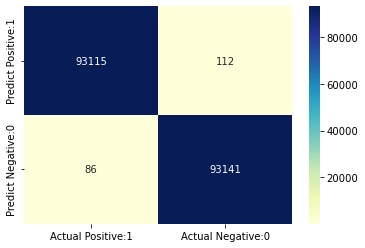

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_train)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Parameter Tuning

In [81]:
def bayes_parameter_opt_lgb(X, y, init_round, opt_round, n_folds, random_seed, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y)
    # parameters
    def lgb_eval(learning_rate,num_leaves, max_depth, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc', "feature_pre_filter": False,}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['max_depth'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (20, 90),
                                            'max_depth': (5, 30),
                                            'min_data_in_leaf': (20, 100),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

optimal_params = bayes_parameter_opt_lgb(X_train_lgb, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6)

|   iter    |  target   | learni... | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 62151, number of negative: 62151
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 124302, number of used features: 20
[LightGBM] [Info] Number of positive: 62152, number of negative: 62151
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 124303, number of used features: 20
[LightGBM] [Info] Number of positive: 62151, number of negative: 62152
[Ligh

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 124303, number of used features: 20
[LightGBM] [Info] Number of positive: 62151, number of negative: 62152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 124303, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500004 -> initscore=0.000016
[LightGBM] [Info] Start training from score 0.000016
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499996 -> initscore=-0.000016
[LightGBM] [Info] Start training from score -0.000016


C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Start training from score -0.000016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Start training from score -0.000016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 124303, number of used features: 20
[LightGBM] [Info] Number of positive: 62151, number of negative: 62152
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 124303, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500004 -> initscore=0.000016
[LightGBM] [Info] Start training from score 0.000016
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499996 -> initscor

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


| 14        | 1.0       | 0.5972    | 22.18     | 94.34     | 0.2566    | 26.53     | 0.04668   |
[LightGBM] [Info] Number of positive: 62151, number of negative: 62151
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 124302, number of used features: 20
[LightGBM] [Info] Number of positive: 62152, number of negative: 62151
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 124303, number of used features: 20
[LightGBM] [Info] Number of positive: 62151, number of negative: 62152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016372 secon

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
optimal_params[1]["num_leaves"] = int(round(optimal_params[1]["num_leaves"]))
optimal_params[1]['max_depth'] = int(round(optimal_params[1]['max_depth']))
optimal_params[1]['min_data_in_leaf'] = int(round(optimal_params[1]['min_data_in_leaf']))
optimal_params[1]['max_bin'] = 100
optimal_params[1]['objective']='binary'
optimal_params[1]['metric']='auc'
optimal_params =optimal_params[1]
optimal_params

In [90]:
optimal_params

{'learning_rate': 0.1913497663932155,
 'max_depth': 28,
 'min_data_in_leaf': 62,
 'min_sum_hessian_in_leaf': 2.1717094446797702,
 'num_leaves': 55,
 'subsample': 0.6950702461866961,
 'max_bin': 100,
 'objective': 'binary',
 'metric': 'auc'}

In [99]:
#Split train and validation set
trainset_lgb = pd.concat([X_train_lgb, y_train], axis=1)
train_df, val_df = train_test_split(trainset_lgb, test_size=0.9, random_state= 0, shuffle=True)

dtrain = lgb.Dataset(train_df[lgb_features], 
                      label=train_df['is_attributed'],
                      feature_name=lgb_features,
                      categorical_feature=cat_lgb)

dvalid = lgb.Dataset(val_df[lgb_features],
                      label=val_df['is_attributed'],
                      feature_name=lgb_features,
                      categorical_feature=cat_lgb)
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50  #lgb early stop 

In [101]:
 evals_results = {}
model = lgb.train(optimal_params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=EARLY_STOP,
                  verbose_eval=50, 
                  feval=None)

C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\vanes\anaconda3\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is depreca

[LightGBM] [Info] Number of positive: 9262, number of negative: 9383
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 18645, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496755 -> initscore=-0.012980
[LightGBM] [Info] Start training from score -0.012980
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Neural Network - Grid Search

Choosing model based on CV score

In [156]:
def create_model(optimizer, activation, nl, nn):
    model = Sequential()
    #1st hidden layer
    model.add(Dense(nn, input_shape=(16,), activation=activation))

    #remaining hidden layers
    for i in range(1, nl):
        model.add(Dense(nn, activation=activation))
    
    #output (binary)
    model.add(Dense(1, activation="sigmoid"))

    #compile
    model.compile(optimizer=optimizer, loss="binary_crossentropy")

    return model

In [162]:
#Turn keras model to sklearn estimator
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(model=create_model, activation="adam", nl=1, nn=1)

In [165]:
activation = ["relu", "sigmoid", "tanh"]
optimizer = ["adam", "SGD", "RMSprop"]
nl = [1,2,3,4,5,6,7,8,9,10]
nn = [1,2,3,4,5,6,7,8,9,10]

param = {
    "optimizer": optimizer,
    "activation": activation,
    "nl": nl,
    "nn": nn
}

nn_random_search = RandomizedSearchCV(model, param, cv=3)
nn_random_search.fit(X_train_xgb_scaled, y_train, verbose=0)


1943/1943 [==============================] - 8s 4ms/step


RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(activation='adam', model=<function create_model at 0x000002BB19B29280>, nl=1, nn=1),
                   param_distributions={'activation': ['relu', 'sigmoid',
                                                       'tanh'],
                                        'nl': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'nn': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'optimizer': ['adam', 'SGD',
                                                      'RMSprop']})

In [166]:
print(nn_random_search.best_estimator_)
print(nn_random_search.best_params_)
print(nn_random_search.best_score_)

KerasClassifier(
	model=<function create_model at 0x000002BB19B29280>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	activation=relu
	nl=6
	nn=7
	class_weight=None
)
{'optimizer': 'adam', 'nn': 7, 'nl': 6, 'activation': 'relu'}
0.9559301503693246


In [27]:
#fit with best model

best_nn = Sequential()
#1st hidden layer
best_nn.add(Dense(7, input_shape=(16,), activation="relu"))
#remaining hidden layers
for i in range(1, 6):
    best_nn.add(Dense(7, activation="relu"))
#output (binary)
best_nn.add(Dense(1, activation="sigmoid"))
#compile
best_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [29]:
best_nn.fit(X_train_xgb_scaled, y_train)

5827/5827 [==============================] - 38s 6ms/step - loss: 0.1636 - accuracy: 0.9400


In [30]:
#training loss and accuracy
best_nn.evaluate(X_train_xgb_scaled, y_train)

5827/5827 [==============================] - 28s 5ms/step - loss: 0.1228 - accuracy: 0.9564


[0.12276649475097656, 0.956396758556366]

### Neural Network - Bayesian Optimization

In [12]:
# ignore warning to clean up the results
import warnings
warnings.filterwarnings("ignore")

In [32]:
#pip install git+https://github.com/fmfn/BayesianOptimization

  Running command git clone -q https://github.com/fmfn/BayesianOptimization 'C:\Users\vanes\AppData\Local\Temp\pip-req-build-6a91jy9i'



  Cloning https://github.com/fmfn/BayesianOptimization to c:\users\vanes\appdata\local\temp\pip-req-build-6a91jy9i
  Resolved https://github.com/fmfn/BayesianOptimization to commit 05941f75134165506eeb750fb5fc94f4d5668d5c
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.3.0-py3-none-any.whl size=16866 sha256=8492c6da63eef98e8e2756859d8a1754c604a975464a2f6dac4715762feb02f3
  Stored in directory: C:\Users\vanes\AppData\Local\Temp\pip-ephem-wheel-cache-1xg5gndx\wheels\de\4b\fc\ca63ecde7529784254ce89a4c60adafcb973a6b20aa9f18dd4
Successfully built bayesian-optimization


In [13]:
from bayes_opt import BayesianOptimization # Bayesian optimization is more efficient in time and memory capacity for tuning many hyperparameters
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
LeakyReLU = LeakyReLU(alpha=0.1)
score_acc = make_scorer(accuracy_score)

Tune hyperparameters of the model (without layer)

In [18]:
# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    # optimizer
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl', 'SGD']
    optimizerD= {'SGD':SGD(learning_rate=learning_rate), 'Adam':Adam(learning_rate=learning_rate), 
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    # activation function
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU, 'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = Adam(learning_rate = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=16, activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20) # EarlyStopping is used to stop the learning process if there is no accuracy improvement in 20 epochs
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(nn, X_train_xgb_scaled, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [19]:
# Set paramaters
params_nn ={
    'neurons': (1, 16),
    'activation':(0, 9),
    'optimizer':(0,8),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------
1166/1166 [==============================] - 2s 1ms/step
| 1         | 0.5592    | 5.51      | 335.3     | 54.88     | 0.7716    | 5.43      | 1.193     |
1166/1166 [==============================] - 2s 1ms/step
| 2         | 0.7886    | 0.2023    | 536.2     | 39.09     | 0.3443    | 15.86     | 1.902     |
1166/1166 [==============================] - 2s 2ms/step
| 3         | 0.9795    | 0.7307    | 735.7     | 69.7      | 0.2815    | 7.993     | 0.9469    |
1166/1166 [==============================] - 2s 1ms/step
| 4         | 0.8603    | 0.6656    | 920.6     | 83.52     | 0.8422    | 13.23     | 7.928     |
1166/1166 [==============================] - 1s 886us/step
| 5         | 0.9835    | 5.195     | 851.0     | 53.71     | 0.03717   | 7.812     | 0.8426    |
1166/1166 [================

1166/1166 [==============================] - 2s 1ms/step
| 19        | 0.9742    | 0.8254    | 703.8     | 92.23     | 0.3464    | 10.79     | 7.401     |
1166/1166 [==============================] - 2s 1ms/step
| 20        | 0.9596    | 3.366     | 817.1     | 91.69     | 0.624     | 3.266     | 2.999     |
1166/1166 [==============================] - 2s 1ms/step
| 21        | 0.6407    | 5.723     | 567.3     | 62.58     | 0.3588    | 10.9      | 3.812     |
1166/1166 [==============================] - 2s 1ms/step
| 22        | 0.9273    | 4.091     | 299.8     | 53.0      | 0.2804    | 6.201     | 7.795     |
1166/1166 [==============================] - 2s 2ms/step
| 23        | 0.7463    | 1.94      | 746.3     | 22.54     | 0.837     | 11.52     | 7.728     |
1166/1166 [==============================] - 2s 1ms/step
| 24        | 0.9844    | 5.326     | 373.9     | 77.54     | 0.04056   | 7.281     | 2.25      |
1166/1166 [==============================] - 1s 899us/step
| 25       

In [21]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU]
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
optimizerD= {'SGD':SGD(learning_rate=learning_rate), 'Adam':Adam(learning_rate=learning_rate), 
             'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
             'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
             'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'sigmoid',
 'batch_size': 541,
 'epochs': 87,
 'learning_rate': 0.11930722873107395,
 'neurons': 16,
 'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop at 0x14d1ea01240>}

In [22]:
score = nn_cl_bo(**nn_bo.max['params'])
print(f'Cross validation score: {score}')

1166/1166 [==============================] - 1s 997us/step
Cross validation score: 0.9879219447917393


Tune hyperparameters of the model (with layer)

In [23]:
# Create function (consider layer)
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    # optimizer
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl', 'SGD']
    optimizerD= {'SGD':SGD(learning_rate=learning_rate), 'Adam':Adam(learning_rate=learning_rate), 
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    # activation function
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU, 'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=16, activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization()) # It serves to speed up training and use higher learning rates
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=1))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20) # EarlyStopping is used to stop the learning process if there is no accuracy improvement in 20 epochs
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(nn, X_train_xgb_scaled, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [24]:
# Set paramaters (consider layer)
params_nn2 ={
    'neurons': (1, 16),
    'activation':(0, 9),
    'optimizer':(0,8),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,5),
    'layers2':(1,5),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_bo2 = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo2.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
1166/1166 [==============================] - 2s 1ms/step
| 1         | 0.971     | 5.51      | 335.3     | 0.4361    | 0.2308    | 43.63     | 1.597     | 1.09      | 0.426     | 4.58      | 0.3377    | 7.926     |
1166/1166 [==============================] - 2s 2ms/step
| 2         | 0.5       | 2.14      | 265.0     | 0.6696    | 0.1864    | 41.94     | 2.865     | 1.473     | 0.08322   | 14.51     | 0.794     | 6.725     |
1166/1166 [==============================] - 1s 1ms/step
| 3         | 0.5       | 7.337     | 992.8     | 0.5773    | 0.2441    | 53.71     | 1.11      | 2.817     | 0.1143    | 13.26     | 0.6977    | 4.522     |
1166/1166 [============================

In [25]:
params_nn_2 = nn_bo2.max['params']
learning_rate2 = params_nn_2['learning_rate']
activationL2 = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU]
params_nn_2['activation'] = activationL[round(params_nn_2['activation'])]
params_nn_2['batch_size'] = round(params_nn_2['batch_size'])
params_nn_2['epochs'] = round(params_nn_2['epochs'])
params_nn_2['layers1'] = round(params_nn_2['layers1'])
params_nn_2['layers2'] = round(params_nn_2['layers2'])
params_nn_2['neurons'] = round(params_nn_2['neurons'])
optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
optimizerD= {'SGD':SGD(learning_rate=learning_rate2), 'Adam':Adam(learning_rate=learning_rate2), 
             'RMSprop':RMSprop(learning_rate=learning_rate2), 'Adadelta':Adadelta(learning_rate=learning_rate2),
             'Adagrad':Adagrad(learning_rate=learning_rate2), 'Adamax':Adamax(learning_rate=learning_rate2),
             'Nadam':Nadam(learning_rate=learning_rate2), 'Ftrl':Ftrl(learning_rate=learning_rate2)}
params_nn_2['optimizer'] = optimizerD[optimizerL[round(params_nn_2['optimizer'])]]
params_nn_2

{'activation': 'softplus',
 'batch_size': 921,
 'dropout': 0.8182638736220813,
 'dropout_rate': 0.11976995858293202,
 'epochs': 86,
 'layers1': 2,
 'layers2': 3,
 'learning_rate': 0.4183500837466161,
 'neurons': 15,
 'normalization': 0.8253804525121795,
 'optimizer': <keras.optimizers.optimizer_v2.adagrad.Adagrad at 0x14d1c1bfd60>}

In [26]:
score2 = nn_cl_bo2(**nn_bo2.max['params'])
print(f'Cross validation score: {score2}')

1166/1166 [==============================] - 2s 1ms/step
Cross validation score: 0.9908342079854815


### Random Forest Classifier

In [13]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train_xgb, y_train)
y_pred_train_rfc = rfc.predict(X_train_xgb)

In [14]:
evaluation_metrics(y_train, y_pred_train_rfc)

Confusion matrix:
 [[93227     0]
 [    0 93227]] 

Accuracy: 1.0 

Precision: 1.0 

Recall: 1.0


In [15]:
# Check parameters because model is likely to be overfitting
print('Parameters currently in use:\n')
print(rfc.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [37]:
# Tuning
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [38]:
# Use random grid to search for best hyperparameters
# Random search of parameters, using 5 fold cross validation, 
# search across 10 different combinations, and use all available cores
rfc_search = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = random_grid, 
                               n_iter = 10, 
                               cv = 5, 
                               verbose = 3, 
                               random_state = 0, 
                               n_jobs = -1)

In [ ]:
# Fit the random search model
rfc_search.fit(X_train_xgb, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
print(rfc_search.best_estimator_)
print(rfc_search.best_params_)
print(rfc_search.best_score_)

In [ ]:
# fit best RandomForestClassifier on training set
rfc_best = RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_leaf=2,
                       n_estimators=600, random_state=0)

rfc_best.fit(X_train_xgb, y_train)
y_pred_rfc_best = rfc_best.predict(X_train_xgb)

In [ ]:
evaluation_metrics(y_train, y_pred_rfc_best)

### SVM Classifier

In [12]:
from sklearn.svm import SVC

svc = SVC(random_state = 0, max_iter = 10000)
svc.fit(X_train_xgb_scaled, y_train)
y_pred_svc = svc.predict(X_train_xgb_scaled)

/Users/jiashang/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [13]:
evaluation_metrics(y_train, y_pred_svc)

Confusion matrix:
 [[87998  5229]
 [ 2472 90755]] 

Accuracy: 0.9586975876087399 

Precision: 0.9455221703617269 

Recall: 0.9734840765014428


In [14]:
print('Parameters currently in use:\n')
print(svc.get_params())

Parameters currently in use:

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 10000, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [ ]:
# Tuning
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svc_grid = GridSearchCV(svc, 
                        param_grid, 
                        refit = True, 
                        verbose = 0, 
                        cv = 5)
  
# fitting the model for grid search
svc_grid.fit(X_train_xgb_scaled, y_train)

/Users/jiashang/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jiashang/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jiashang/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jiashang/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jiashang/opt/anaconda3/lib/python3.9/site-packages/sk

In [ ]:
print(svc_grid.best_estimator_)
print(svc_grid.best_params_)
print(svc_grid.best_score_)

In [ ]:
# fit best SVM Classifier on training set
# svc_best = 

# svc_best.fit(X_train_xgb_scaled, y_train)
# y_pred_svc_best = svc_best.predict(X_train_xgb_scaled)

In [ ]:
# # Confusion matrix
# print('Confusion matrix:\n', metrics.confusion_matrix(y_train, y_pred_svc_best), '\n')

# # Accuracy
# print('Accuracy:', metrics.accuracy_score(y_train, y_pred_svc_best), '\n')

# # Precision
# print('Precision:', metrics.precision_score(y_train, y_pred_svc_best), '\n')

# # Recall
# print('Recall:', metrics.recall_score(y_train, y_pred_svc_best))

### XGBoost

In [23]:
xgb = XGBClassifier()
xgb.fit(X_train_xgb_scaled, y_train)
y_pred_xgb = xgb.predict(X_train_xgb_scaled)

In [25]:
def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93224
           1       1.00      1.00      1.00     93230

    accuracy                           1.00    186454
   macro avg       1.00      1.00      1.00    186454
weighted avg       1.00      1.00      1.00    186454



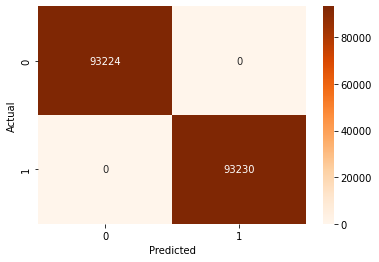

In [26]:
# Performance on training set --> likely to be overfitted, need to re-evaluate features to choose
score_model(xgb, X_train_xgb_scaled, y_pred_xgb)

## Prepare Testing Set

In [10]:
import pandas as pd
test = pd.read_csv('./test_sampled.csv')

In [5]:
test.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,second,dayOfWeek,ip_app_device_nextClick,ip_app_os_nextClick,ip_app_channel_nextClick,ip_device_os_nextClick,ip_device_channel_nextClick,ip_os_channel_nextClick
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,7,3,26242.0,NaN,NaN,34837.0,NaN,NaN
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,59,2,21921.0,8605.0,34514.0,64119.0,34514.0,27490.0
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,34,1,6466.0,17811.0,6466.0,4961.0,6466.0,NaN
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,50,1,10809.0,NaN,10809.0,69966.0,10809.0,NaN
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,14,3,1946.0,NaN,1946.0,78833.0,1946.0,NaN


In [36]:
test_processed = pd.read_csv('./test_processed.csv')

In [37]:
test_processed.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks,device_ip,ip_nextClick,ip_app_nextClick,ip_device_nextClick,ip_os_nextClick,ip_channel_nextClick
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,0,0,0,42,13,31945.0,26242.0,31945.0,34837.0,NaN
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,0,0,0,50,15,38780.0,21921.0,38780.0,64119.0,34514.0
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,0,0,0,16,12,14807.0,6466.0,14807.0,4961.0,6466.0
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,0,0,0,33,19,373.0,10809.0,373.0,69966.0,10809.0
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,0,0,0,8,112,40571.0,1946.0,40571.0,78833.0,1946.0


### Create new features for testing set

In [11]:
# day, hour, minute, second, dayOfWeek
test_datetime = pd.to_datetime(test['click_time'], format='%Y-%m-%d %H:%M:%S')
test['click_time'] = test_datetime
test['day'] = test_datetime.dt.day
test['hour'] = test_datetime.dt.hour
test['minute'] = test_datetime.dt.minute
test['second'] = test_datetime.dt.second
test["dayOfWeek"] = test_datetime.dt.weekday

In [8]:
#total counts
test = agg_counts(test, ["ip", "app", "device", "os", "channel"], 'ip_app_dev_os_cha_counts')
test = agg_counts(test, ["ip", "app", "device", "os"], 'ip_app_dev_os_counts')
test = agg_counts(test, ["ip", "app", "device"], 'ip_app_dev_counts')
test = agg_counts(test, ["ip", "app", "os"], 'ip_app_os_counts')
test = agg_counts(test, ["ip", "app", "hour"], 'ip_app_hour_counts')
test = agg_counts(test, ["ip", "channel"], 'ip_channel_counts')
test = agg_counts(test, ["ip", "app"], 'ip_app_counts')
test = agg_counts(test, ["ip", "day"], 'ip_per_day')
test = agg_counts(test, ["ip"], "ip_counts")

In [9]:
#unique counts
test = agg_unique(test, ["ip"], "app", "uniq_app_per_ip")
test = agg_unique(test, ["ip"], "device", "uniq_device_per_ip")
test = agg_unique(test, ["ip"], "channel", "uniq_channel_per_ip")
test = agg_unique(test, ["ip"], "os", "uniq_os_per_ip")
test = agg_unique(test, ["ip", "device", "os"], "app", "uniq_app_per_ip_dev_os")
test = agg_unique(test, ["app"], "channel", "uniq_channel_per_app")
test = agg_unique(test, ["ip", "day"], "hour", "uniq_hour_per_ip_day")
test = agg_unique(test, ["ip", "app"], "os", "uniq_os_per_ip_app")

In [10]:
#cumulative counts
test = agg_cum_count(test, ["ip"], "cum_count_by_ip")
test = agg_cum_count(test, ["ip", "device"], "cum_count_by_ip_device")
test = agg_cum_count(test, ["ip", "device","os"], "cum_count_by_ip_device_os")
test = agg_cum_count(test, ["ip", "device","os","channel"], "cum_count_by_ip_device_os_channel")
test = agg_cum_count(test, ["ip", "device","os","channel","app"], "cum_count_by_ip_device_os_channel_app")
test = agg_cum_count(test, ["app"], "cum_count_by_app")
test = agg_cum_count(test, ["ip", "app"], "cum_count_by_ip_app")

In [11]:
#variance
test = agg_var(test, ["ip","app","channel"], "hour", "var_hour_by_ip_app_channel")
test = agg_var(test, ["ip","app","os"], "hour", "var_hour_by_ip_app_os")
test = agg_var(test, ["ip","app","device"], "hour", "var_hour_by_ip_app_device")
test = agg_var(test, ["ip","app","channel"], "dayOfWeek", "var_day_by_ip_app_channel")
test = agg_var(test, ["ip","app","os"], "dayOfWeek", "var_day_by_ip_app_os")
test = agg_var(test, ["ip","app","device"], "dayOfWeek", "var_day_by_ip_app_device")

In [12]:
#mean
test = agg_mean(test, ["ip","app","channel"], "hour", "mean_hour_by_ip_app_channel")
test = agg_mean(test, ["ip","app","os"], "hour", "mean_hour_by_ip_app_os")
test = agg_mean(test, ["ip","app","device"], "hour", "mean_hour_by_ip_app_device")

In [12]:
# time till next click
GROUP_BY_NEXT_CLICKS = [
    
    # ip with one other feature
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'device']},
    {'groupby': ['ip', 'os']},
    {'groupby': ['ip', 'channel']},
    
    
    # ip with two other features
    {'groupby': ['ip', 'app', 'device']},
    {'groupby': ['ip', 'app', 'os']},
    {'groupby': ['ip', 'app', 'channel']},
    {'groupby': ['ip', 'device', 'os']},
    {'groupby': ['ip', 'device', 'channel']},
    {'groupby': ['ip', 'os', 'channel']},

    # ip with three other features
    {'groupby': ['ip', 'app', 'device', 'os']},
    {'groupby': ['ip', 'app', 'device', 'channel']},
    {'groupby': ['ip', 'device', 'os', 'channel']},

    # ip with all other features
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    test[new_feature] = test[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds

>> Grouping by ['ip', 'app', 'device', 'os'], and saving time to next click in: ip_app_device_os_nextClick
>> Grouping by ['ip', 'app', 'device', 'channel'], and saving time to next click in: ip_app_device_channel_nextClick
>> Grouping by ['ip', 'device', 'os', 'channel'], and saving time to next click in: ip_device_os_channel_nextClick
>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to next click in: ip_app_device_os_channel_nextClick


In [13]:
# clicks on app ad before & after
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    test['prev_'+fname] = test.groupby(fset).cumcount().rename('prev_'+fname)
        
    # Clicks in the future
    test['future_'+fname] = test.iloc[::-1].groupby(fset).cumcount().rename('future_'+fname).iloc[::-1]

In [52]:
# combining device & ip
test['device_ip'] = test['device'].map(str) + test['ip'].map(str)
# combining device & hour
test['device_hour'] = test['device'].map(str) + test['hour'].map(str)

In [55]:
test_processed.to_csv('./test_processed.csv', index=False)